## Fitness Tracker Analysis

### 1 - Overview

Inspired by the Quantified Self authoried by Mark Hoogendoorn and the availability of sample fitness data, and with Dave Ebbelaar's guidance, I wanted to explore machine learning models to classify: 

1) the type of movement, 
2) the number of repetitions of that movement, and 
3) the number of sets per workout. 

Such an use case would be helpful because I'm not a fan of writing down how many sets and reps I did for each workout. Instead, the classification algorithm can do all of that while I go by "feel" of exercising to near-failure, thereby making real progress in strength training, rather than arbitrarily exercising to a predetermined number of reps or sets.

### 2 - The Data

The sample data was recorded using the MetaMotionS, a wearable device that offers real-time and continuous monitoring of motion and environmental sensor data.

This data was collected by Dave Ebbelaar when tracking 5 participants as they performed various barbell exercises.

https://mbientlab.com/metamotions/

All the data is stored in the /data/raw/ folder as multiple .csv files. For each participant and exercise, two sets of data were collected:

| Accelerometer data (meters/second-squared) | Gyroscope data (degrees/seconds) |
| - | - |
| 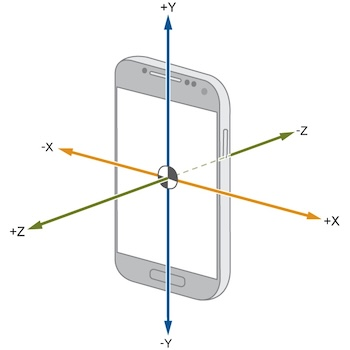 | 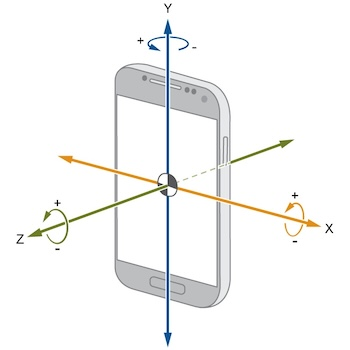 |

All the raw data will be read and marged into a single panda DataFrame with both accelerometer and gyroscope data.

In [73]:
# Import both pandas and glob libraries
import pandas as pd
from glob import glob

# Set the path to the data files
data_path = "../data/raw/*.csv"
files = glob(data_path)

# Read all files using a function and combine them into 2 sets
def read_data_from_files(files):

    acc_df = pd.DataFrame()
    gyr_df = pd.DataFrame()

    acc_set = 1
    gyr_set = 1

    # Loop through all the files in the directory
    for f in files:

        # Create new features from filename - participant, label, category
        participant = f.split("-")[0].replace(data_path.rstrip("*.csv"), "")
        label = f.split("-")[1]
        category = f.split("-")[2].rstrip("123").rstrip("_MetaWear_2019")

        df = pd.read_csv(f)

        df["participant"] = participant
        df["label"] = label
        df["category"] = category

        # Organize data into two datasets - Accelerometer and Gyroscope
        if "Accelerometer" in f:
            df["set"] = acc_set
            acc_set += 1
            acc_df = pd.concat([acc_df, df])

        if "Gyroscope" in f:
            df["set"] = gyr_set
            gyr_set += 1
            gyr_df = pd.concat([gyr_df, df])

    # Append each file to each corresponding dataset
    acc_df.index = pd.to_datetime(acc_df["epoch (ms)"], unit="ms")
    gyr_df.index = pd.to_datetime(gyr_df["epoch (ms)"], unit="ms")

    # Remove extra time-based columns (no longer needed)
    del acc_df["epoch (ms)"]
    del acc_df["time (01:00)"]
    del acc_df["elapsed (s)"]

    del gyr_df["epoch (ms)"]
    del gyr_df["time (01:00)"]
    del gyr_df["elapsed (s)"]

    # Return the combined datasets
    return acc_df, gyr_df

# Call the read_data_from_files() function
acc_df, gyr_df = read_data_from_files(files)

In [74]:
# Merge the two datasets into a single DataFrame

data_merged = pd.concat([acc_df.iloc[:, :3], gyr_df], axis=1)

data_merged.columns = [
    "acc_x",
    "acc_y",
    "acc_z",
    "gyr_x",
    "gyr_y",
    "gyr_z",
    "participant",
    "label",
    "category",
    "set",
]

Upon inspection of the merged dataset using the ```.head()``` and ```.info()``` functions, we immediately see a problem. The accelerometer and gyroscope data have been recorded at different timestamps. 

In [75]:
data_merged.info()
data_merged.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69677 entries, 2019-01-11 15:08:04.950000 to 2019-01-20 17:35:13.702000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        23578 non-null  float64
 1   acc_y        23578 non-null  float64
 2   acc_z        23578 non-null  float64
 3   gyr_x        47218 non-null  float64
 4   gyr_y        47218 non-null  float64
 5   gyr_z        47218 non-null  float64
 6   participant  47218 non-null  object 
 7   label        47218 non-null  object 
 8   category     47218 non-null  object 
 9   set          47218 non-null  float64
dtypes: float64(7), object(3)
memory usage: 5.8+ MB


acc_x  acc_y  acc_z   gyr_x  gyr_y  gyr_z  \
epoch (ms)                                                           
2019-01-11 15:08:04.950    NaN    NaN    NaN -10.671 -1.524  5.976   
2019-01-11 15:08:04.990    NaN    NaN    NaN  -8.720 -2.073  3.171   
2019-01-11 15:08:05.030    NaN    NaN    NaN   0.488 -3.537 -4.146   
2019-01-11 15:08:05.070    NaN    NaN    NaN   0.244 -5.854  3.537   
2019-01-11 15:08:05.110    NaN    NaN    NaN  -0.915  0.061 -2.805   

                        participant  label category   set  
epoch (ms)                                                 
2019-01-11 15:08:04.950           B  bench    heavy  64.0  
2019-01-11 15:08:04.990           B  bench    heavy  64.0  
2019-01-11 15:08:05.030           B  bench    heavy  64.0  
2019-01-11 15:08:05.070           B  bench    heavy  64.0  
2019-01-11 15:08:05.110           B  bench    heavy  64.0

To address the timestamp mismatch issue, we'll try resampling the data to 200ms while taking the mean of all numerical values except the ```set``` feature. This way, we should have both accelerometer and gyroscope data at each 200ms interval.  

In [76]:
sampling = {
    "acc_x": "mean",
    "acc_y": "mean",
    "acc_z": "mean",
    "gyr_x": "mean",
    "gyr_y": "mean",
    "gyr_z": "mean",
    "participant": "last",
    "label": "last",
    "category": "last",
    "set": "last",
}

data_merged[:1000].resample(rule="200ms").apply(sampling)


acc_x     acc_y     acc_z    gyr_x    gyr_y  \
epoch (ms)                                                                
2019-01-11 15:08:04.800       NaN       NaN       NaN -9.69550  -1.7985   
2019-01-11 15:08:05.000       NaN       NaN       NaN -2.01220  -0.4270   
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.89040   2.4392   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.68260  -0.8904   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.56080  -0.2560   
...                           ...       ...       ...      ...      ...   
2019-01-11 15:10:21.600 -0.174000  1.092667 -0.153333 -4.96360 -16.4026   
2019-01-11 15:10:21.800 -0.219500  1.402500 -0.109000 -7.52440  18.6706   
2019-01-11 15:10:22.000 -0.192000  0.871667 -0.155667  2.60980   8.7070   
2019-01-11 15:10:22.200 -0.227000  0.891000 -0.170000  5.39020   4.0000   
2019-01-11 15:10:22.400 -0.225500  0.919500 -0.205500  6.34125   0.5795   

                           gyr_z participant  label category   set  
epoch (ms)                                                          
2019-01-11 15:08:04.800   4.5735           B  bench    heavy  64.0  
2019-01-11 15:08:05.000  -1.6218           B  bench    heavy  64.0  
2019-01-11 15:08:05.200   0.9388           B  bench    heavy  64.0  
2019-01-11 15:08:05.400   2.1708           B  bench    heavy  64.0  
2019-01-11 15:08:05.600  -1.4146           B  bench    heavy  64.0  
...                          ...         ...    ...      ...   ...  
2019-01-11 15:10:21.600  21.9026           A  bench    heavy  72.0  
2019-01-11 15:10:21.800 -22.6828           A  bench    heavy  72.0  
2019-01-11 15:10:22.000 -14.8658           A  bench    heavy  72.0  
2019-01-11 15:10:22.200  -0.3780           A  bench    heavy  72.0  
2019-01-11 15:10:22.400   9.9085           A  bench    heavy  72.0  

[689 rows x 10 columns]

Now that the merge and resample worked, split the data by the day and apply this transformation to the rest of the dataframe.

In [77]:
# Split by day
days = [g for n, g in data_merged.groupby(pd.Grouper(freq="D"))]

# Apply sampling to each day for the rest of the dataset
data_resampled = pd.concat(
    [df.resample(rule="200ms").apply(sampling).dropna() for df in days]
)

# Column 'set' was found to be a float64 object upon inspection, convert to int
data_resampled["set"] = data_resampled["set"].astype("int")


Inspect the full resampled dataset to make sure there are no missing values for both accelerometer and gyroscope data at 200ms intervals. 

In [78]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


Save the resampled dataset in an interim folder:

In [79]:
data_resampled.to_pickle("../data/interim/01_data_processed.pkl")


### 3 - Exploratory Analysis and Visualization

Create visualizations to better understand the accelerometer and gyroscope data before running classification models. Exploratory analysis helps to determine what type of feature engineering or scaling is needed. 

The plots are saved in the ../../reports/figures/ folder.

The file naming convention is: '{label}-{participant}.png'

First, import the plotting libraries:

In [80]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

To make the plots look better, adjust the plotting style and settings:

In [81]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100

In [82]:
# Load the data from the pickle file
df = pd.read_pickle("../data/interim/01_data_processed.pkl")


#### 3.1 - Examine a Single Feature

Plot a single column from a single set and inspect one of the accelerometer features:

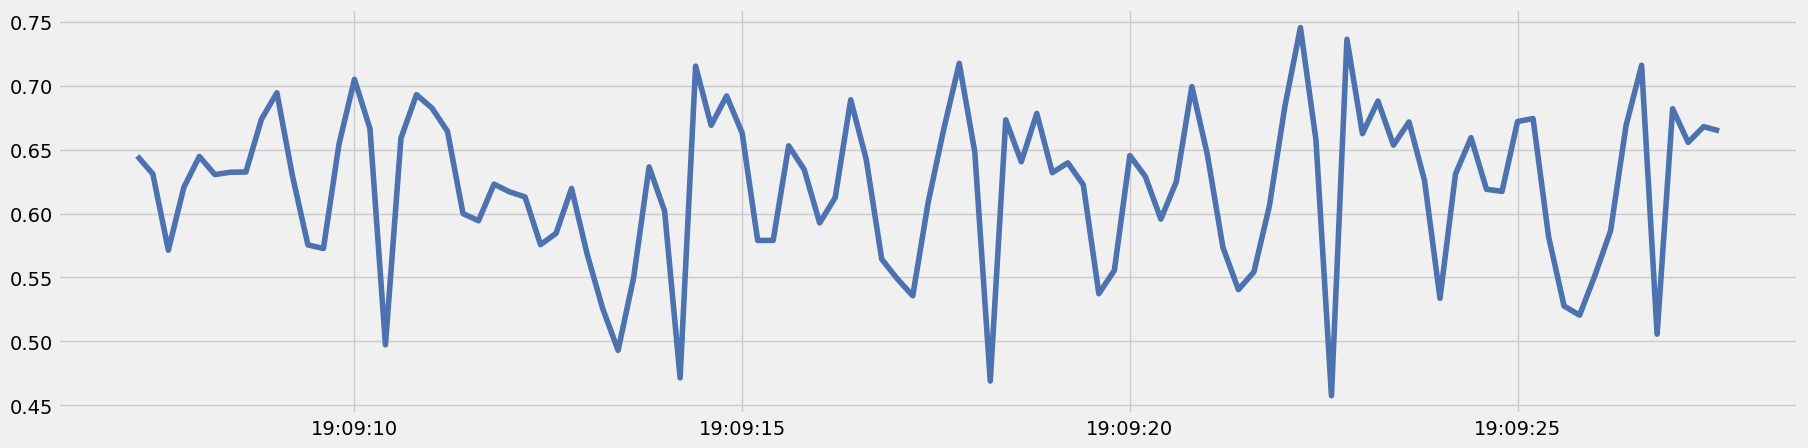

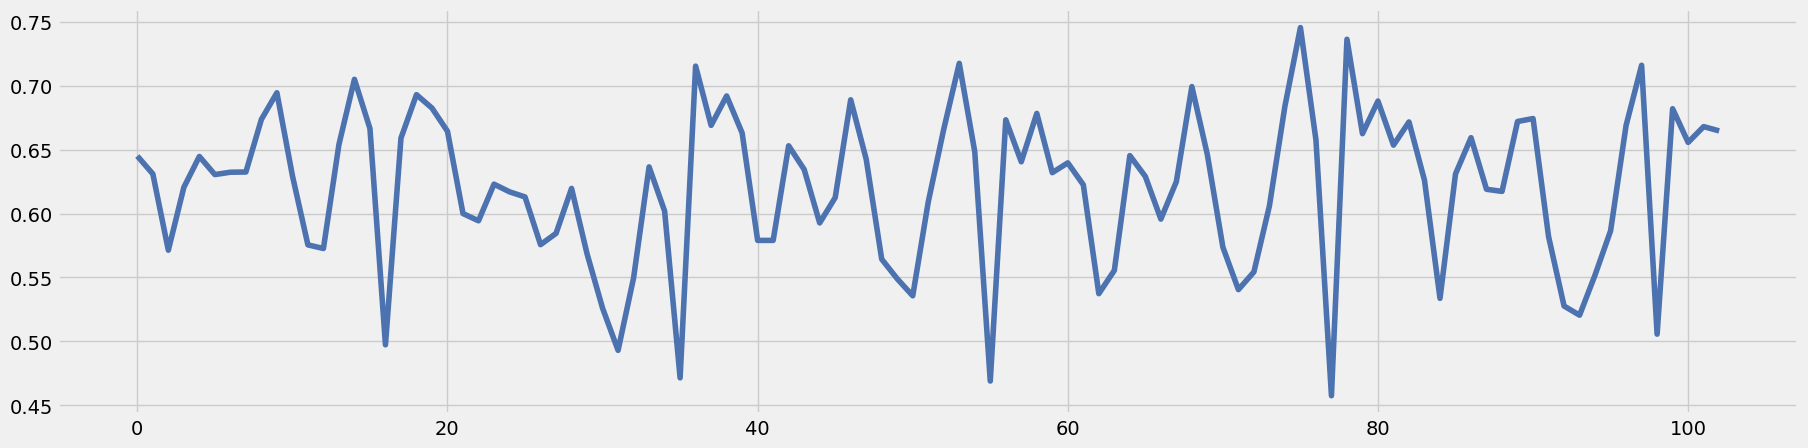

In [83]:
# Select a single subset
set_df = df[df["set"] == 1]
set_df

# Plot y-values over the duration of this set
plt.plot(set_df["acc_y"])
plt.show()

# Plot y-values over the number of samples in this set
plt.plot(set_df["acc_y"].reset_index(drop=True))
plt.show()

From the y-axis of the accelerometer, there seems to be a signal of 4 or 5 sets. However, there is a lot of "noise" that will need to be smoothed out before training the classification models.

#### 3.2 - Examine Exercise Patterns

Next, plot all data for each exercise:

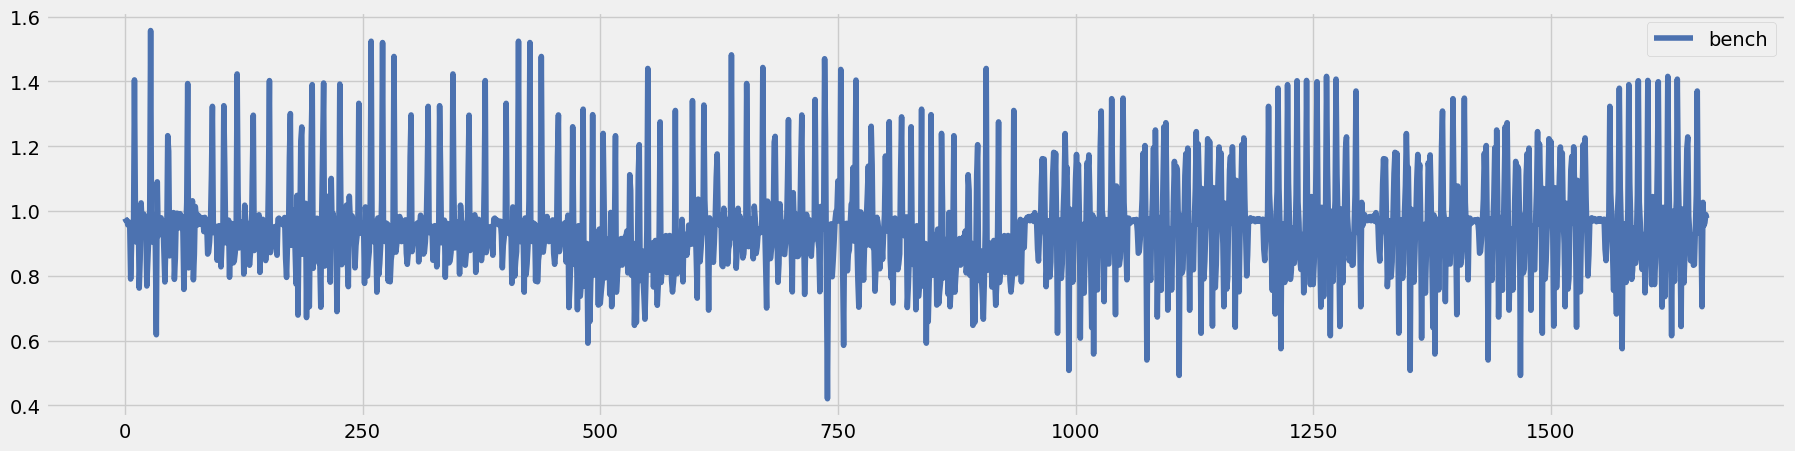

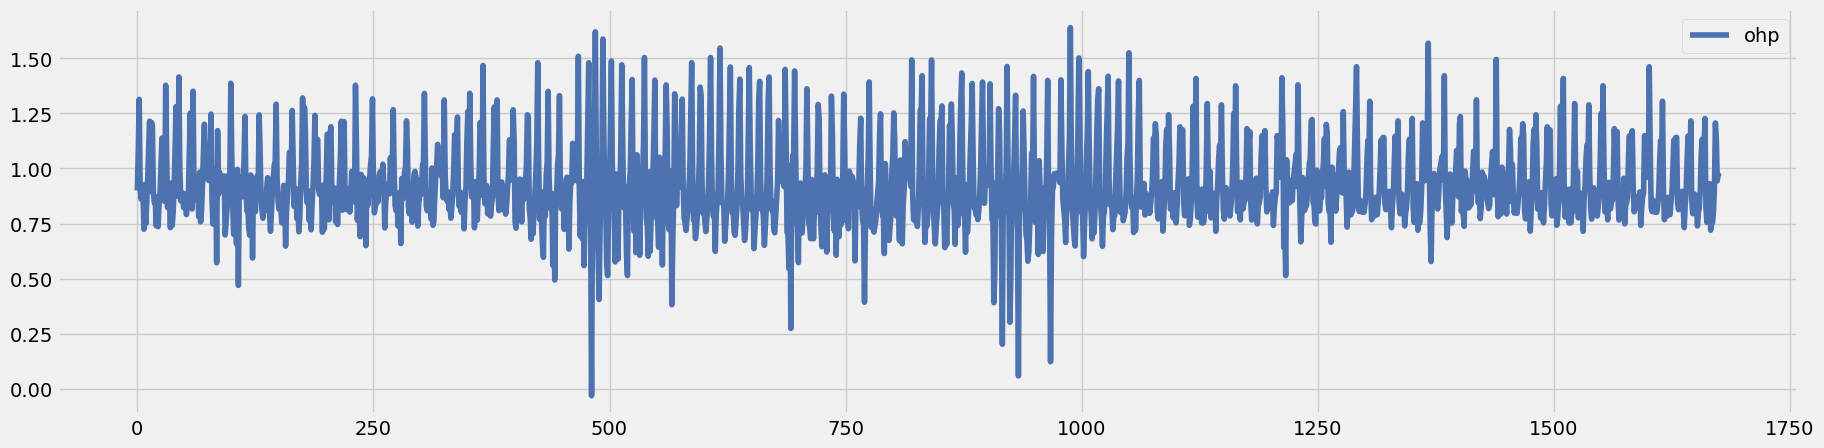

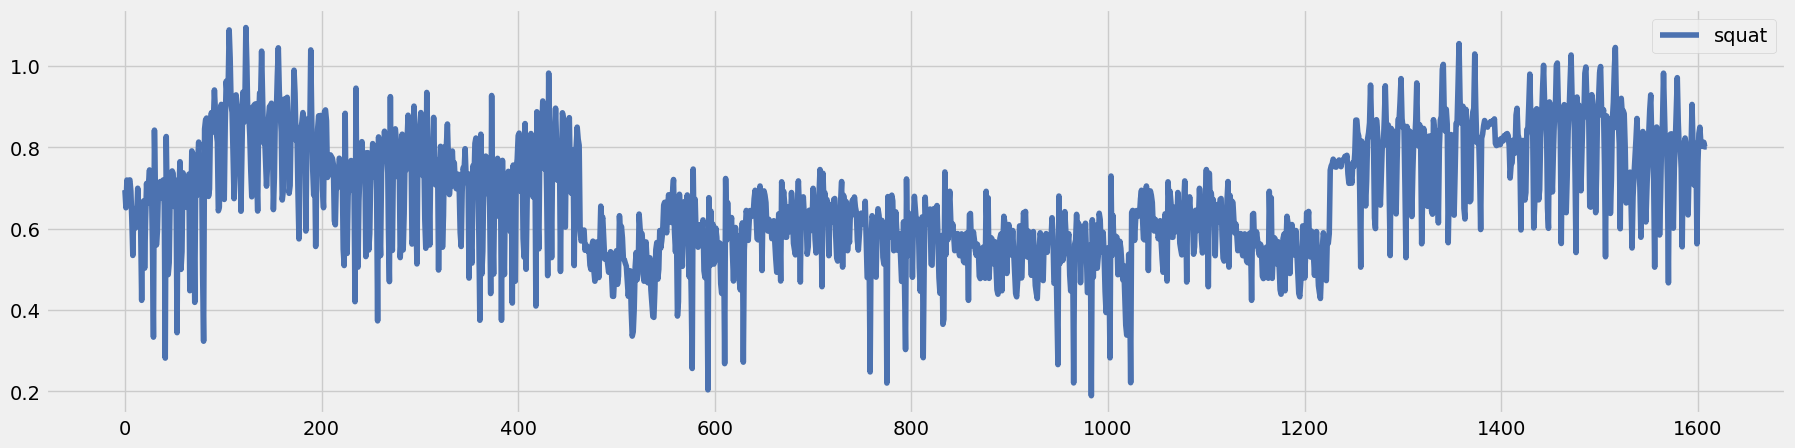

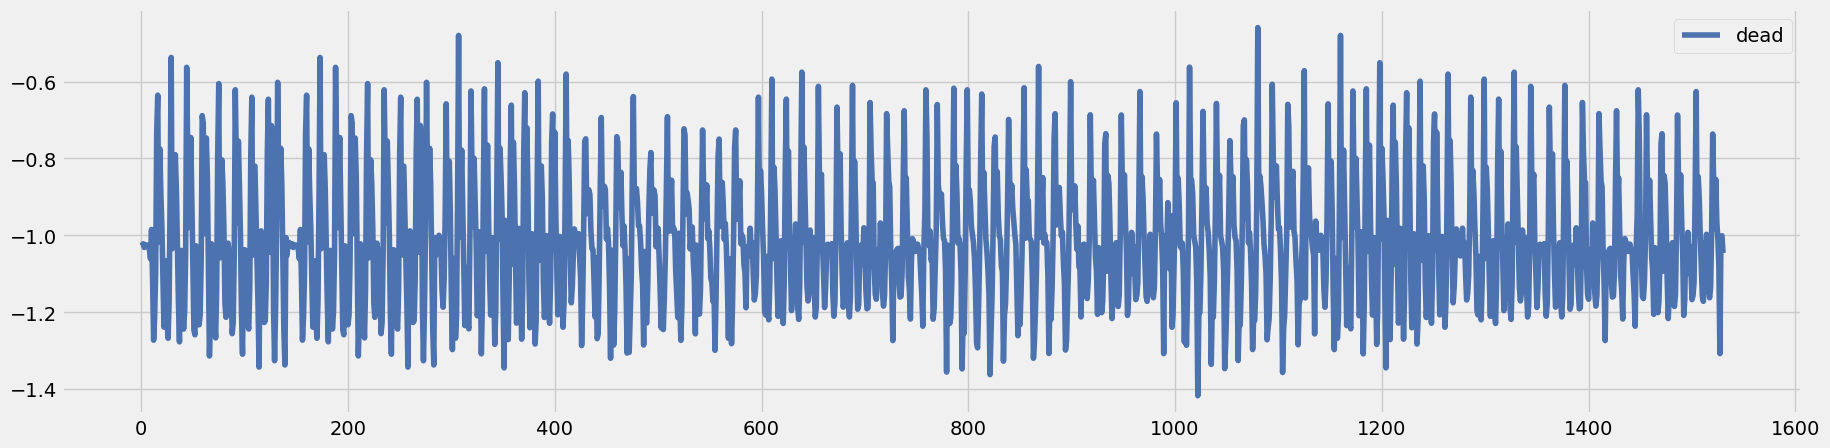

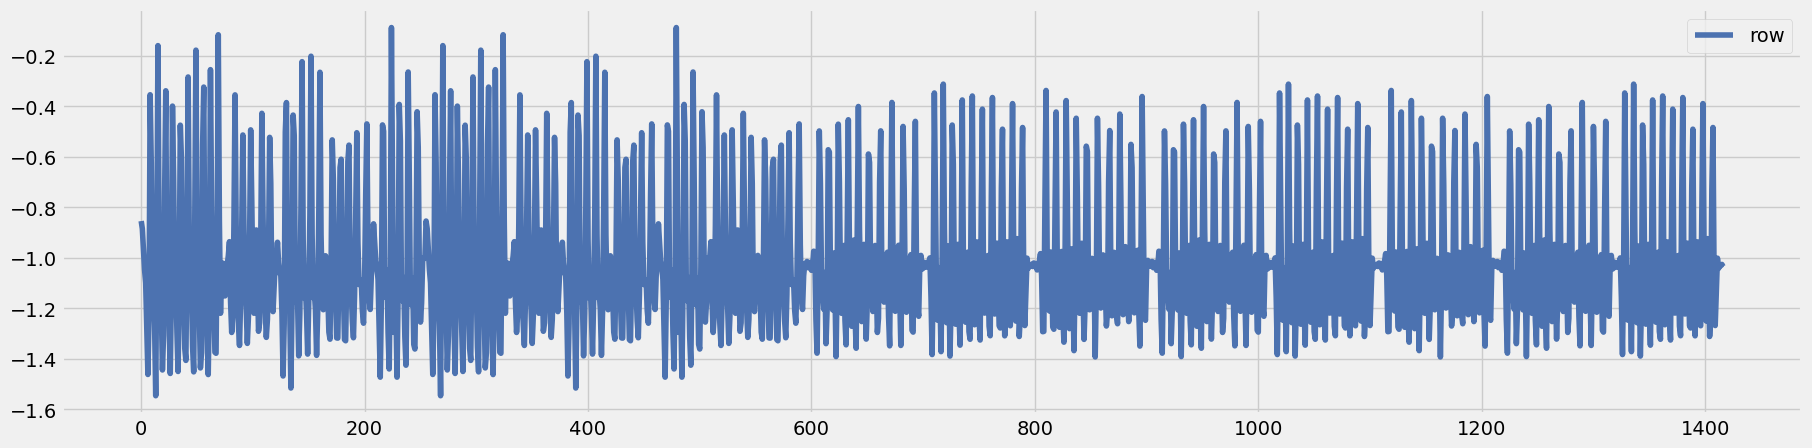

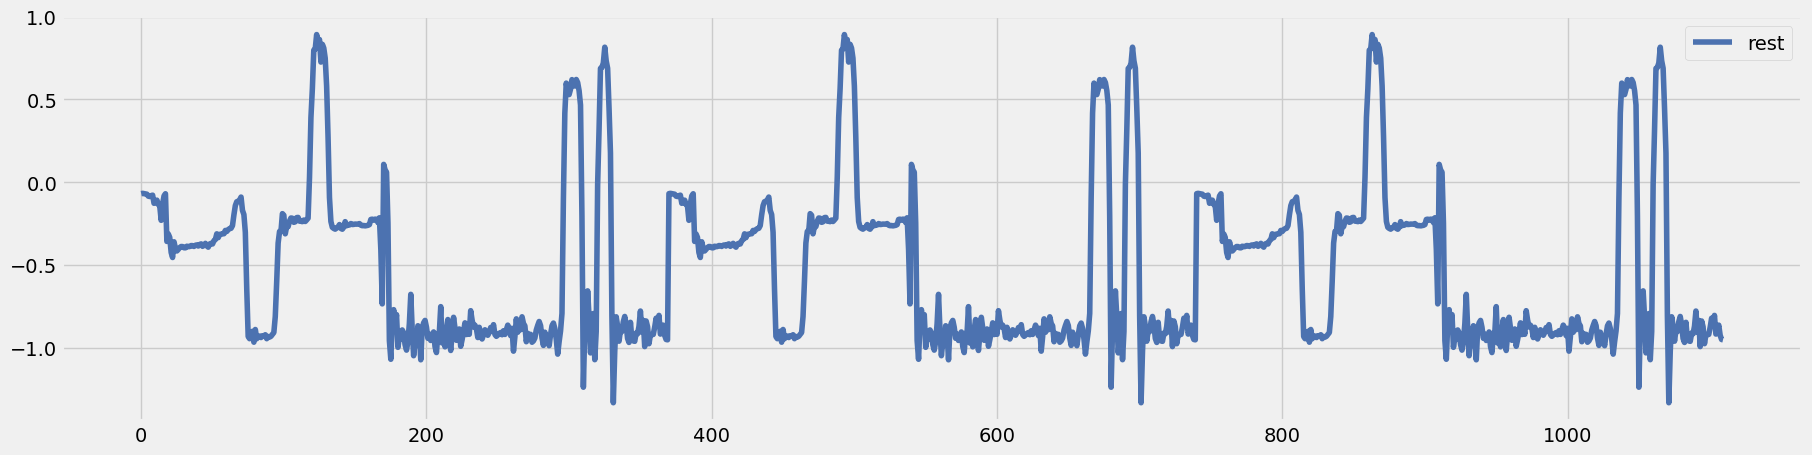

In [84]:
for label in df["label"].unique():
    subset = df[df["label"] == label]
    fig, ax = plt.subplots()
    plt.plot(subset["acc_y"].reset_index(drop=True), label=label)
    plt.legend()
    plt.show()

While there are clear patterns in each exercise over the entire dataset, it would be useful to plot a small portion of each exercise to make the patterns more clearer:

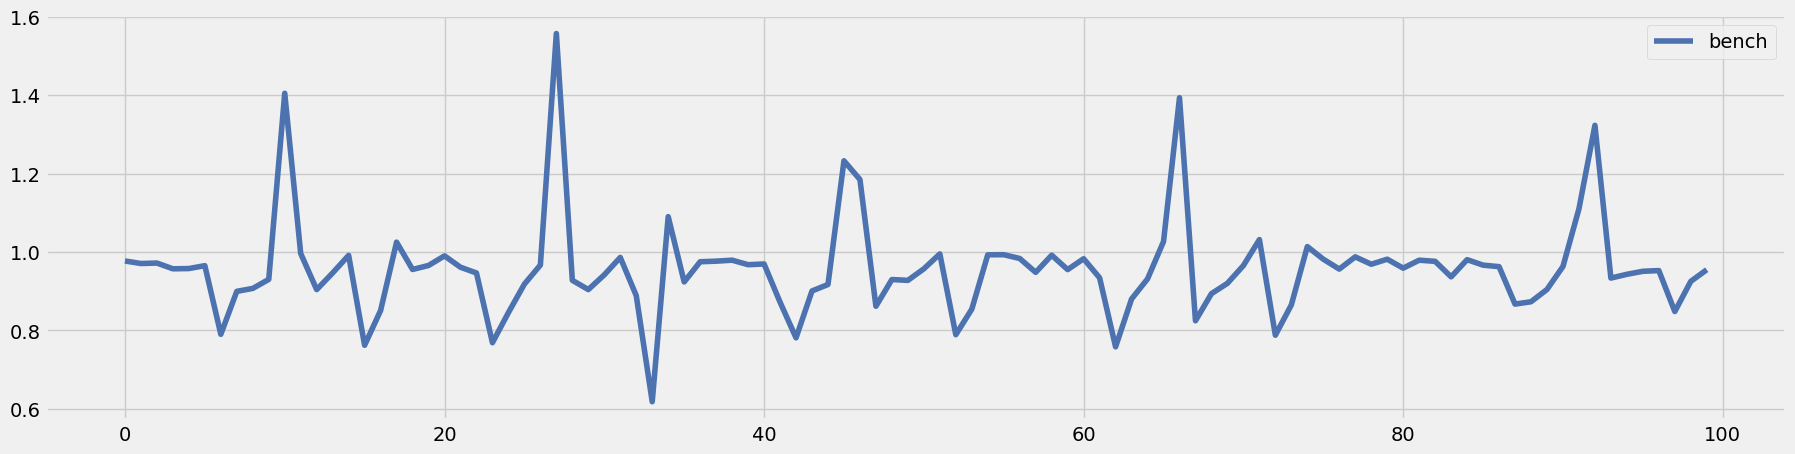

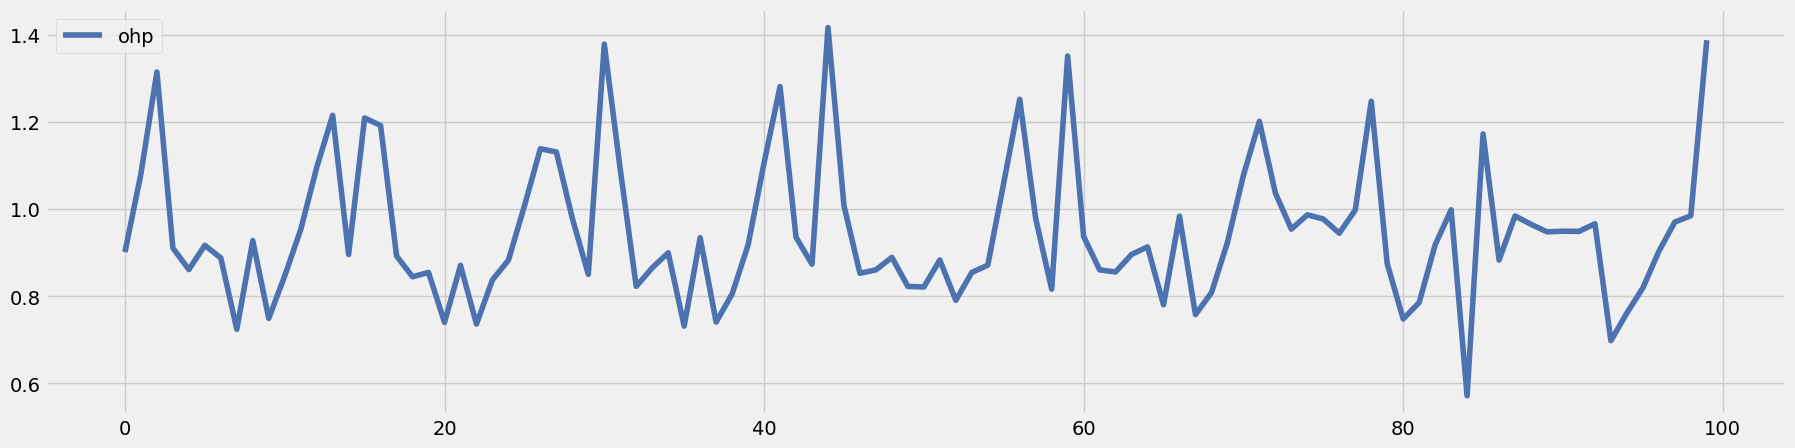

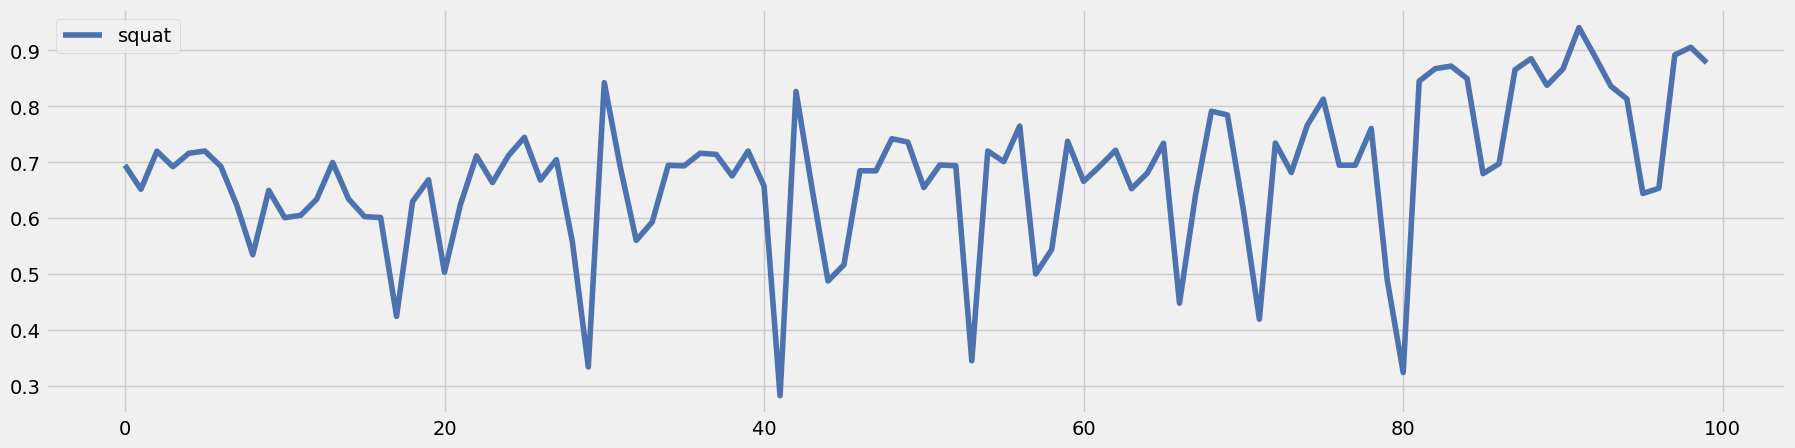

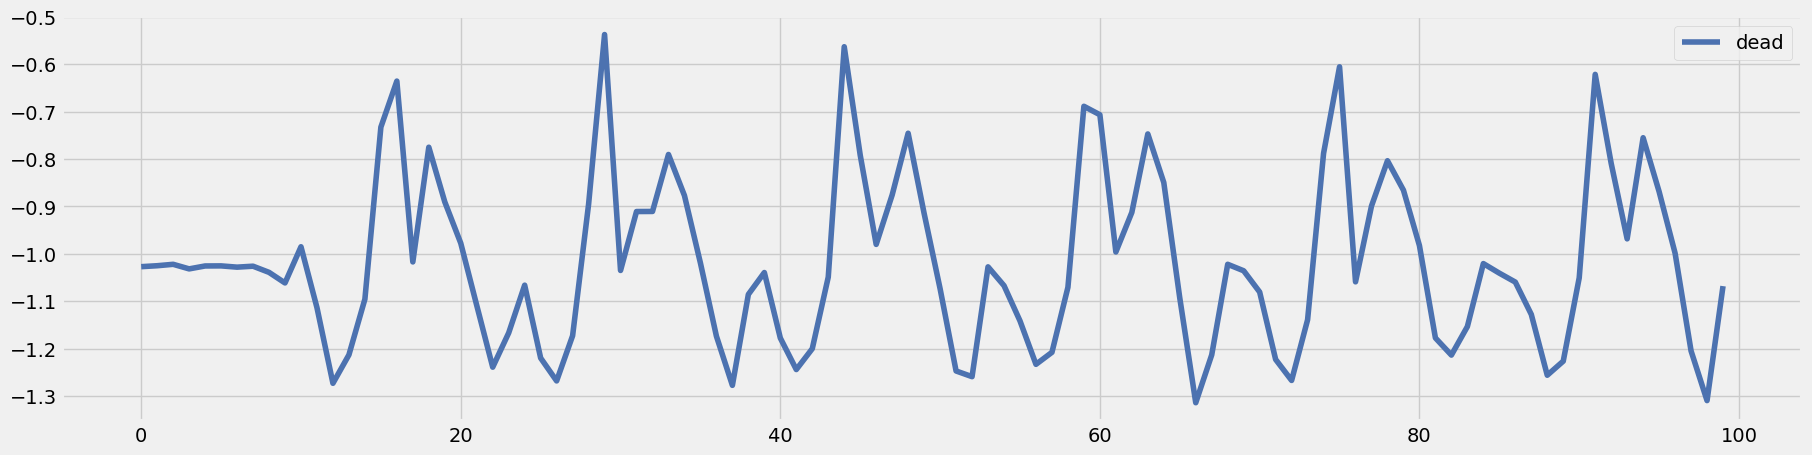

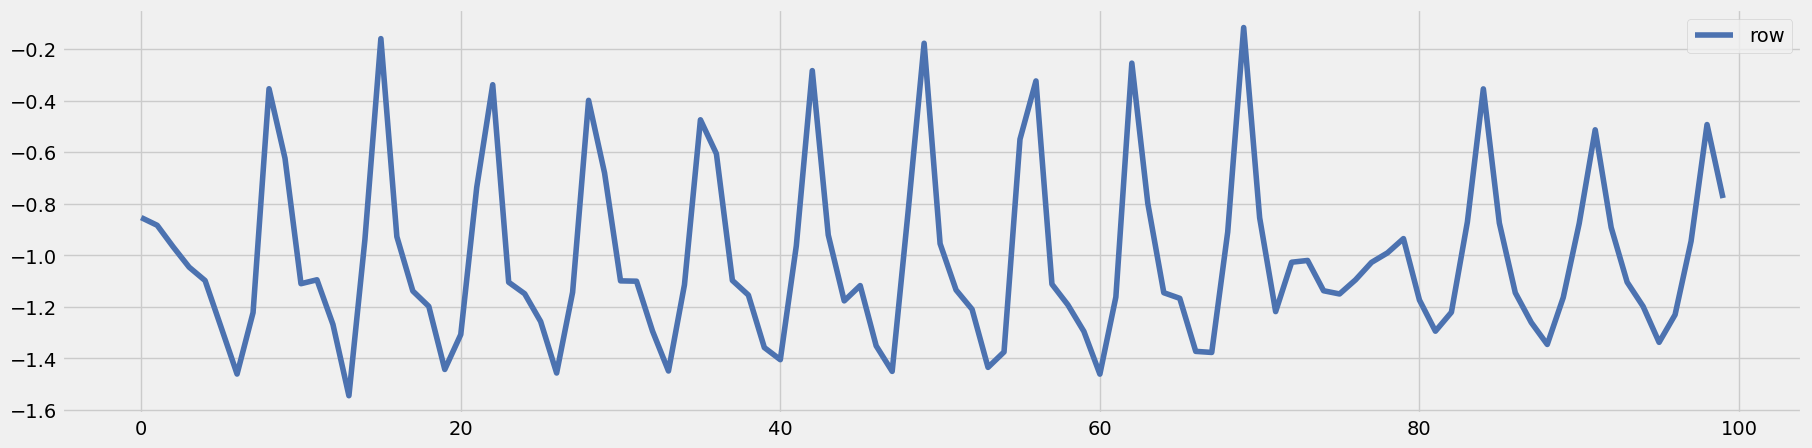

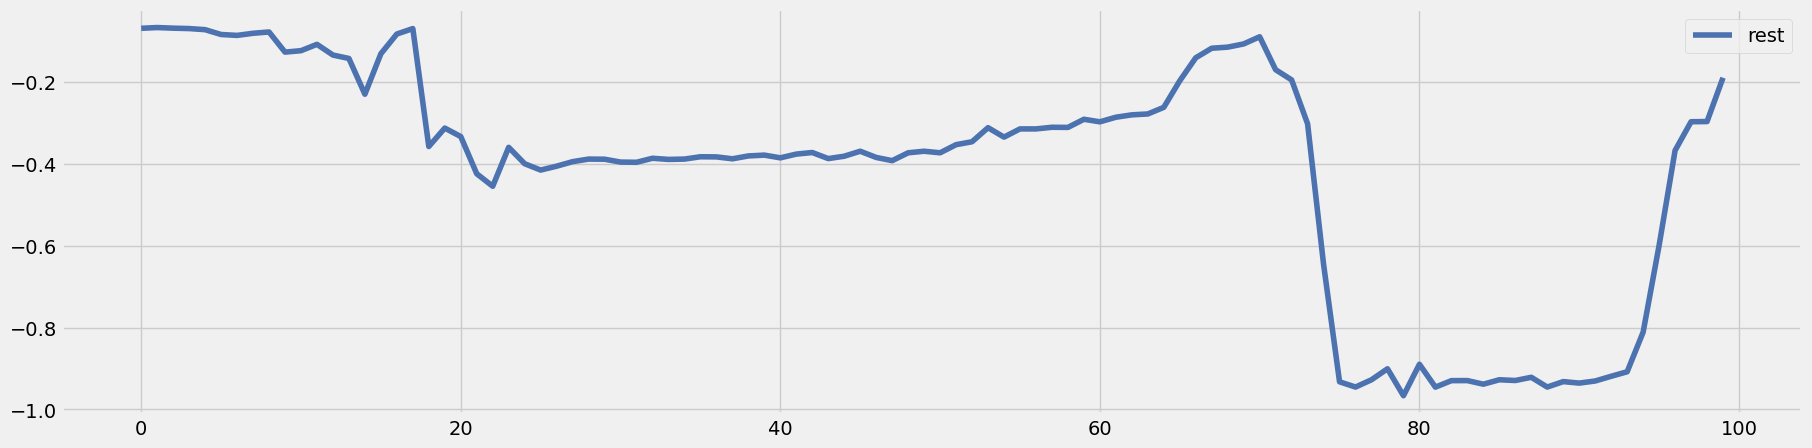

In [85]:
# Plot only the first 100 samples for each exercise
for label in df["label"].unique():
    subset = df[df["label"] == label]
    fig, ax = plt.subplots()
    plt.plot(subset[:100]["acc_y"].reset_index(drop=True), label=label)
    plt.legend()
    plt.show()

#### 3.3 - Examine Medium vs. Heavy Sets

Now we want to examine the ```categories``` feature:

In [86]:
df["category"].unique()

array(['heavy', 'medium', 'sitting', 'standing'], dtype=object)

For each set, we have two categories worth exploring: heavy and medium. We want to visualize comparisions between medium and heavy sets.

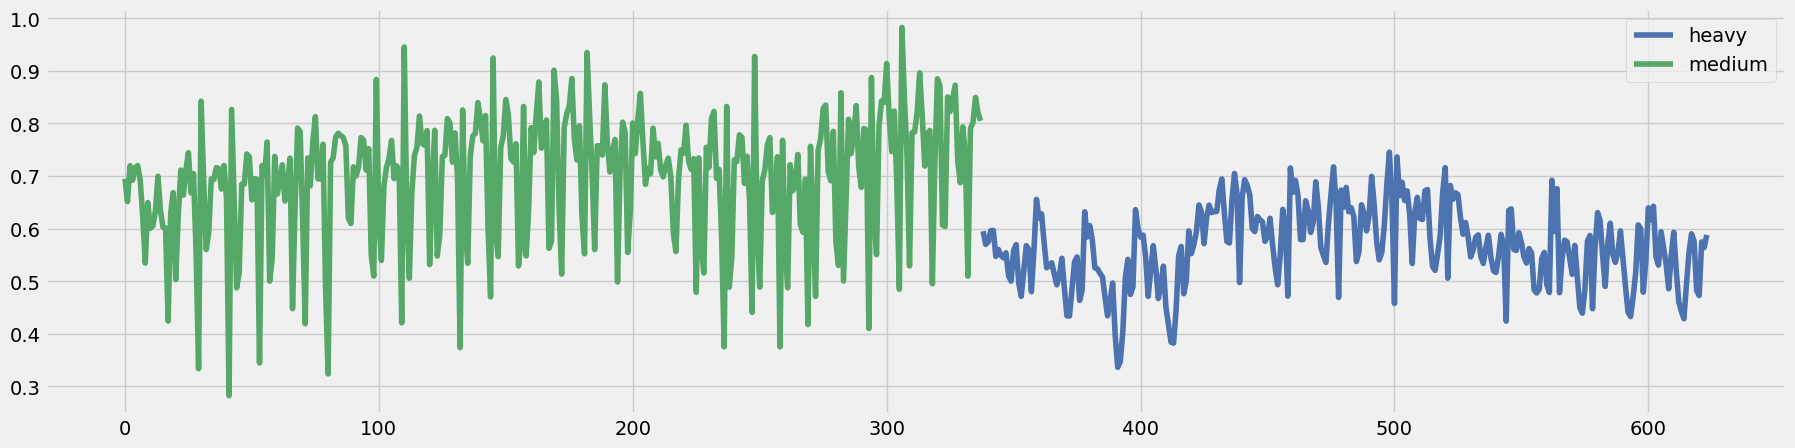

In [87]:
# Stacked queries to pull squat data for participant A
# Add reset_index to make sure the index is continuous (No. of samples)
category_df = df.query("label == 'squat'").query("participant == 'A'").reset_index()

# Group by category (heavy vs. medium) and plot the y-values
fig, ax = plt.subplots()
category_df.groupby(["category"])["acc_y"].plot()
ax.set_ylabel = "acc_y"
ax.set_xlabel = "samples"
plt.legend()

There is a clear difference between medium and heavy sets, with faster accleration on the y-axis for medium sets and slower acceleration on the heavy sets.

#### 3.4 - Examine Exercise Patterns Among Participants

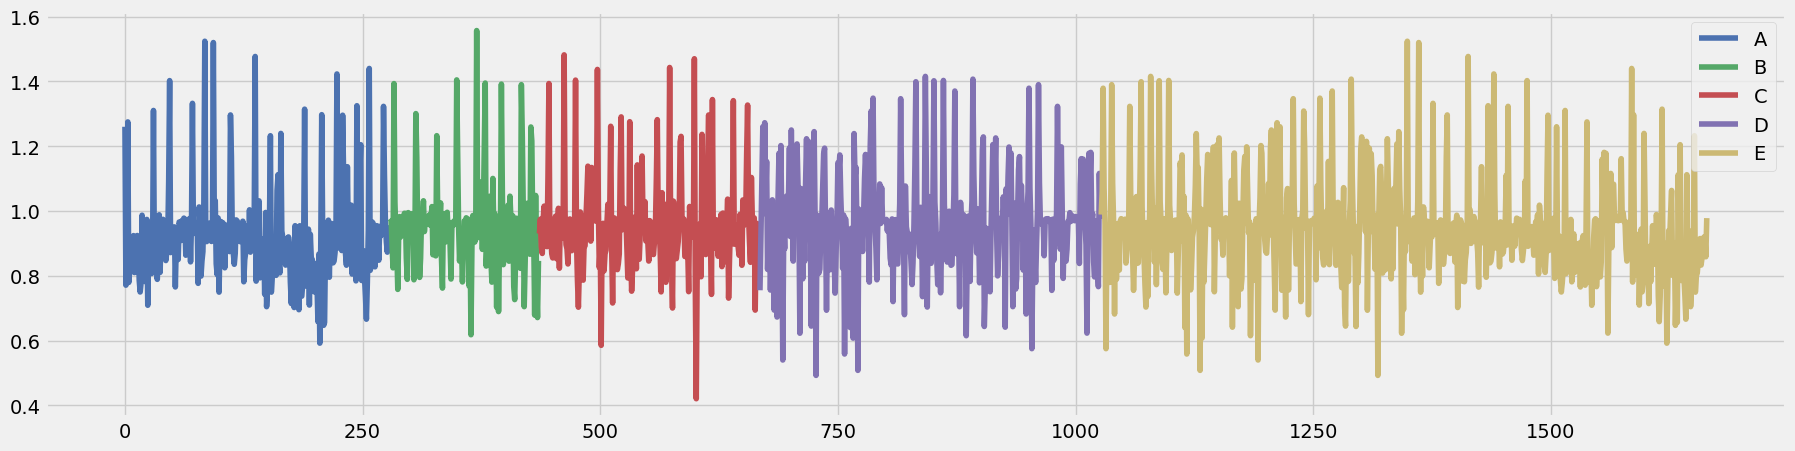

In [88]:
# Pull bench data for all participants (all categories)
participant_df = df.query("label == 'bench'").sort_values("participant").reset_index()

# Group by participant and plot the y-values for benching
fig, ax = plt.subplots()
participant_df.groupby(["participant"])["acc_y"].plot()
ax.set_ylabel = "acc_y"
ax.set_xlabel = "samples"
plt.legend()

Exercise patterns among different participants seem similar for bench press and other excercises, so the classification algorithm should be able to generalize to unseen participants without engineering features based on differences between participants.

#### 3.5 - Plot All Accelerometer Variables In the Same Graph

Examine all accelerometer features ```acc_x```, ```acc_y```, and ```acc_z``` in the same graph.

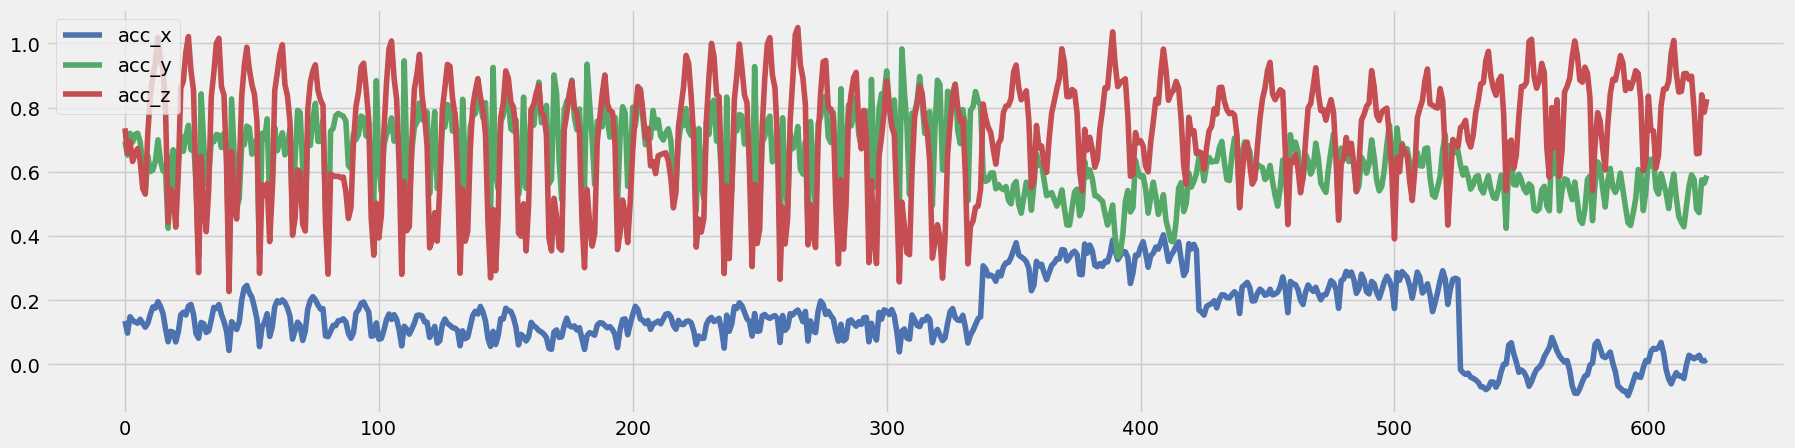

In [89]:
label = "squat"
participant = "A"
all_axis_df = (
    df.query(f"label == '{label}'")
    .query(f"participant == '{participant}'")
    .reset_index()
)

fig, ax = plt.subplots()
all_axis_df[["acc_x", "acc_y", "acc_z"]].plot(ax=ax)
ax.set_ylabel = "acc_y"
ax.set_xlabel = "samples"
plt.legend()


#### 3.6 - Plot All Combinations for Both Accelerometer and Gyroscope Sensors

For each exercise type and participant, plot accelerometer and gyroscope data, and save each plot to file in the `../reports/figures/` folder.

**Warning: Running this cell will create a large number of plots.**

In [90]:
labels = df["label"].unique()
participants = df["participant"].unique()

# Loop through all combinations of labels and participants
for label in labels:
    for participant in participants:
        combined_plot_df = (
            df.query(f"label == '{label}'")
            .query(f"participant == '{participant}'")
            .reset_index()
        )

        if len(combined_plot_df) > 0:
            fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
            combined_plot_df[["acc_x", "acc_y", "acc_z"]].plot(ax=ax[0])
            combined_plot_df[["gyr_x", "gyr_y", "gyr_z"]].plot(ax=ax[1])

            ax[0].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.15),
                ncol=3,
                fancybox=True,
                shadow=True,
            )
            ax[1].legend(
                loc="upper center",
                bbox_to_anchor=(0.5, 1.15),
                ncol=3,
                fancybox=True,
                shadow=True,
            )
            ax[1].set_xlabel("samples")
            plt.savefig(f"../reports/figures/{label.title()}-({participant}).png")
            plt.close()
            
print("All plots have been saved to the ../reports/figures/ folder.")


All plots have been saved to the ../reports/figures/ folder.


### 4 - Detecting Outliers in Sensor Data

The next step is to check whether there are extreme values or outliers in the data that should be removed before modeling.

Load the necessary libraries:

In [98]:
import math
import scipy

array([<Axes: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_z'}, xlabel='[label]'>], dtype=object)

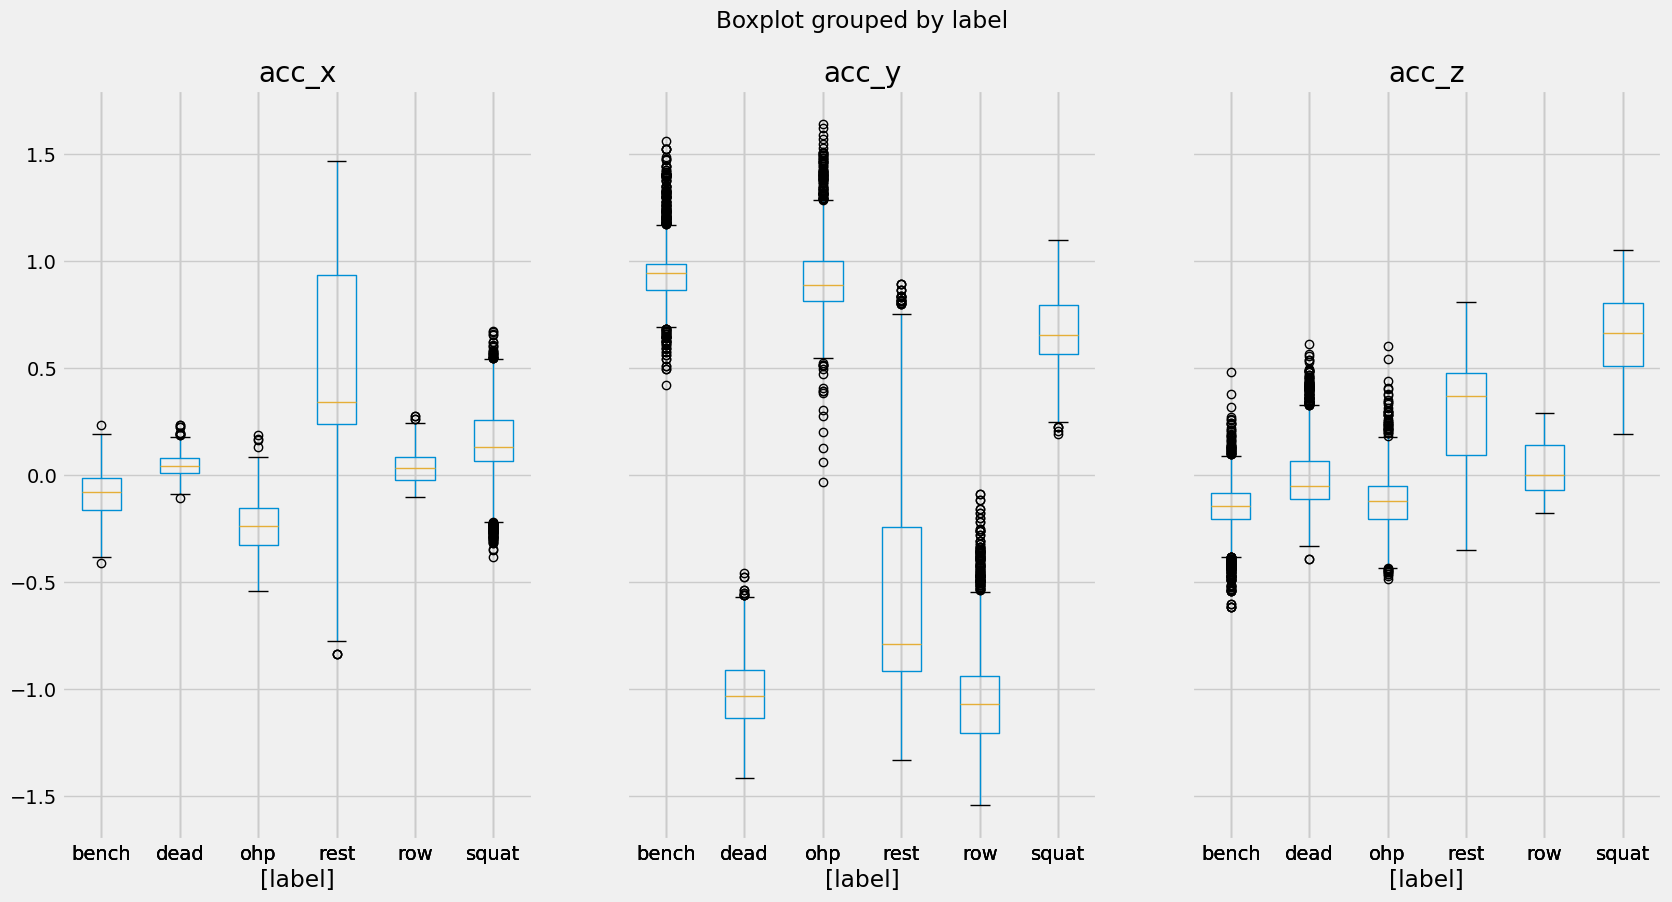

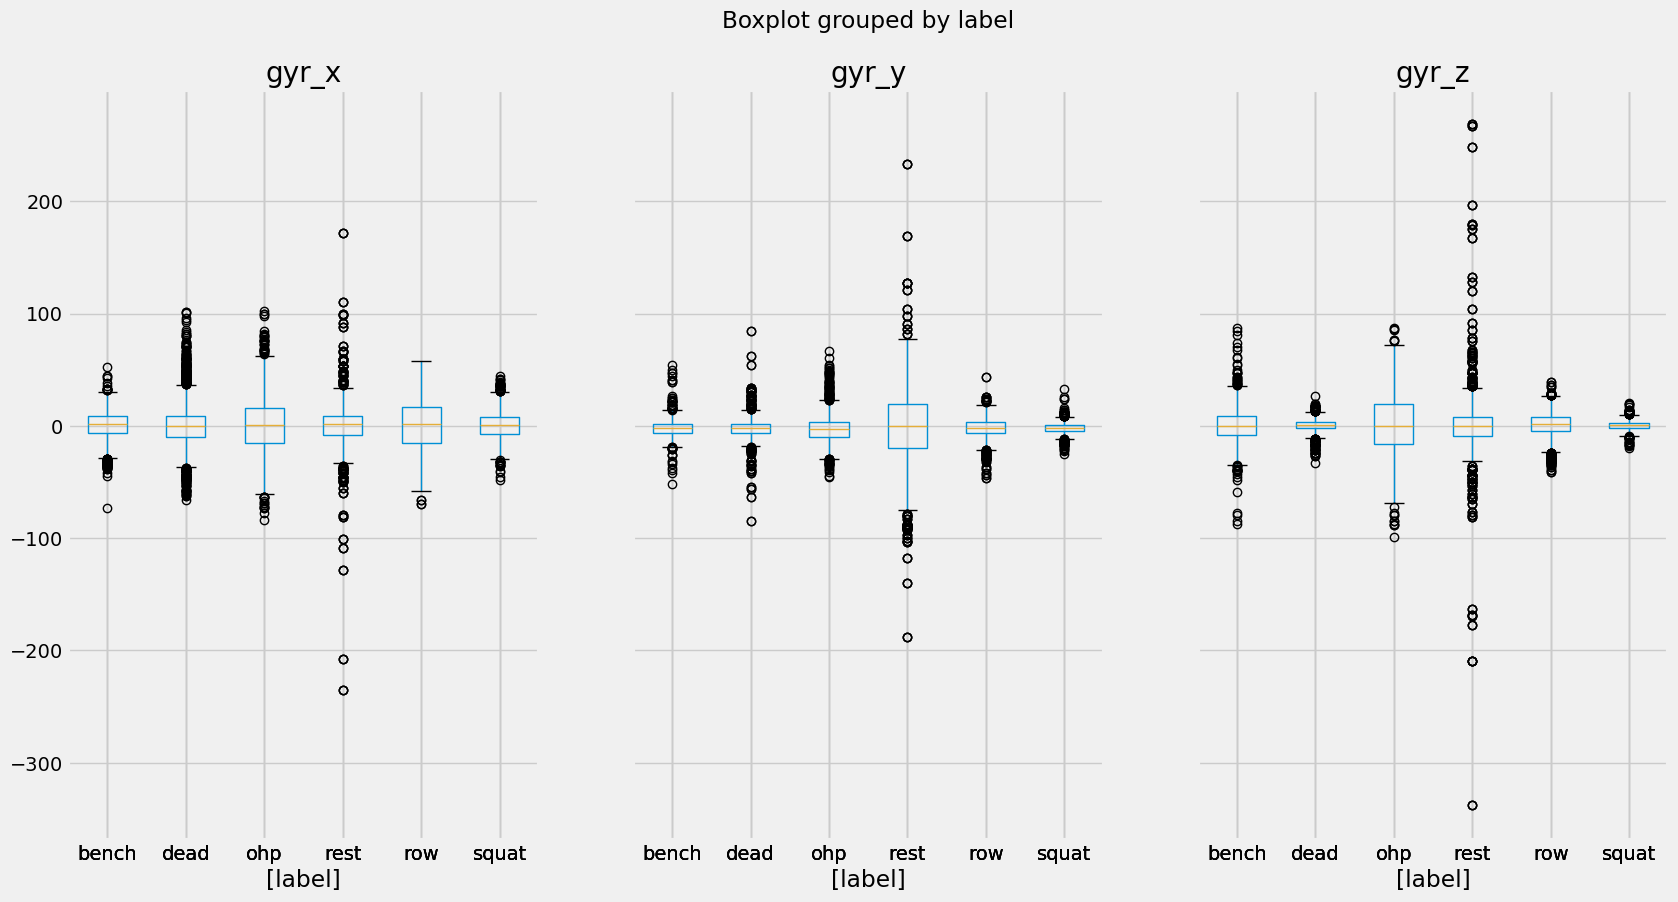

In [92]:
# Use box plots to see the extent of outliers in each type of exercise
outlier_columns = list(df.columns[:6])

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))

Plotting outliers in each set shows a lot of extreme values, but we can't just remove them all using a brute force strategy. We need to visualize them in other ways to see if there's a pattern among these outliers. This way, we can make an informed choice using the outlier detection functions below.


#### 4.1 - Define Binary Outlier Scores

Use Mark Hoogendoorn's function to plot binary outlier scores. Source code can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.

Define `plot_binary_outliers()` as follows:

In [93]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

#### 4.2 - Inquartile Ranges Method for Outlier Detection

When using a boxplot, the box extends from Q1 to Q3 quartile values of the data, when a line across the median (Q2). The whiskers extend from the edges of the box to show the full range of data, including outliers. By default, they extend no more than 1.5 * IQR, where IQR = Q3 - Q1, from the edges of the box. Any data points beyond the whiskers are considered outliers.

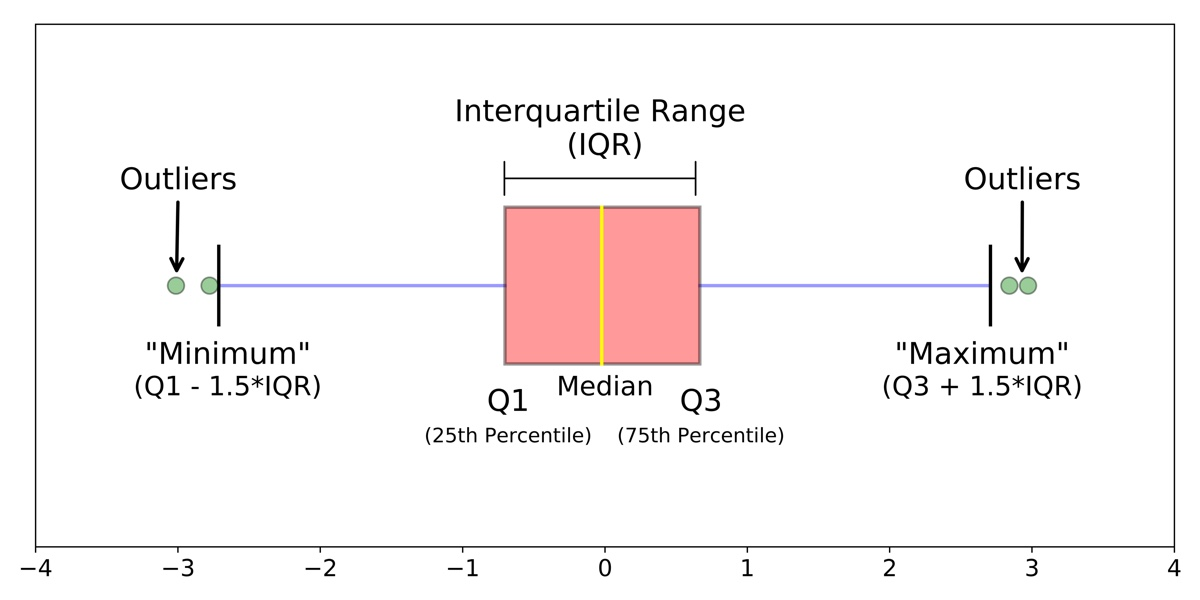

Image from: https://www.linkedin.com/in/michaelgalarnyk/

Define `mark_outliers_iqr()` as follows:

In [94]:
def mark_outliers_iqr(dataset, col):
    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

#### 4.3 - Plotting Outliers Using the Boxplot and IQR Method

Test this method and mark outliers as red, normal data points as blue.

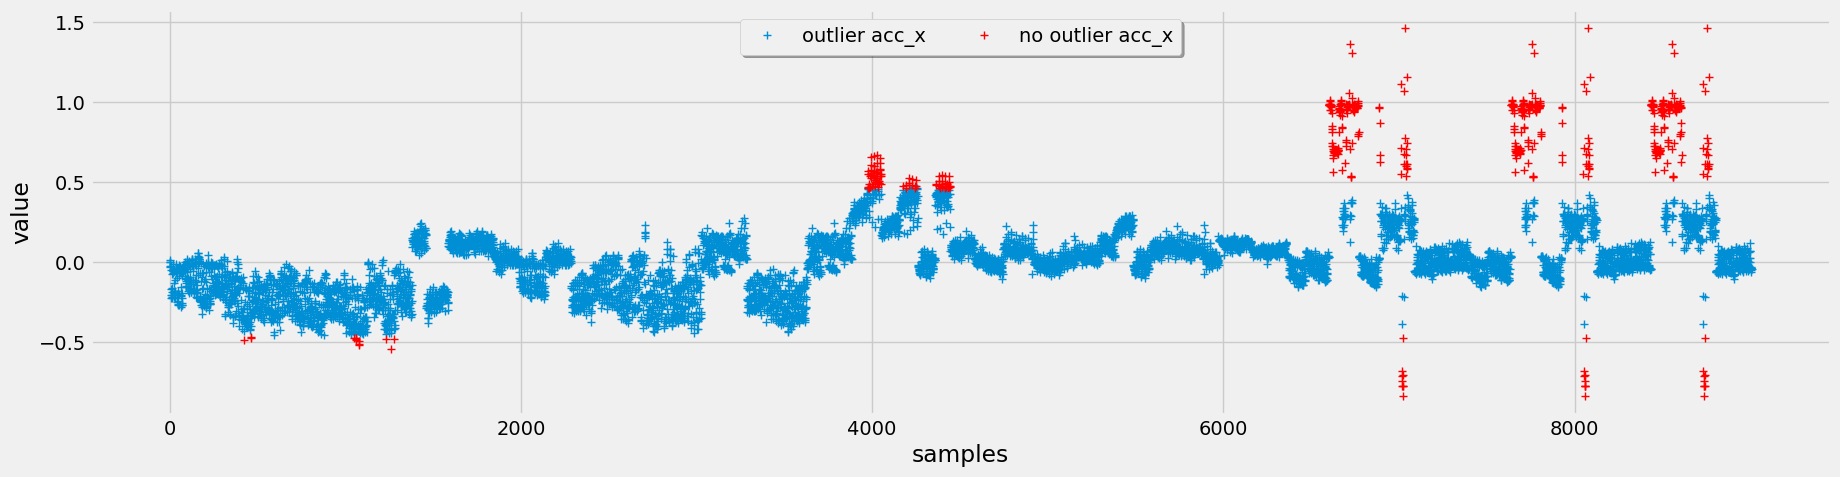

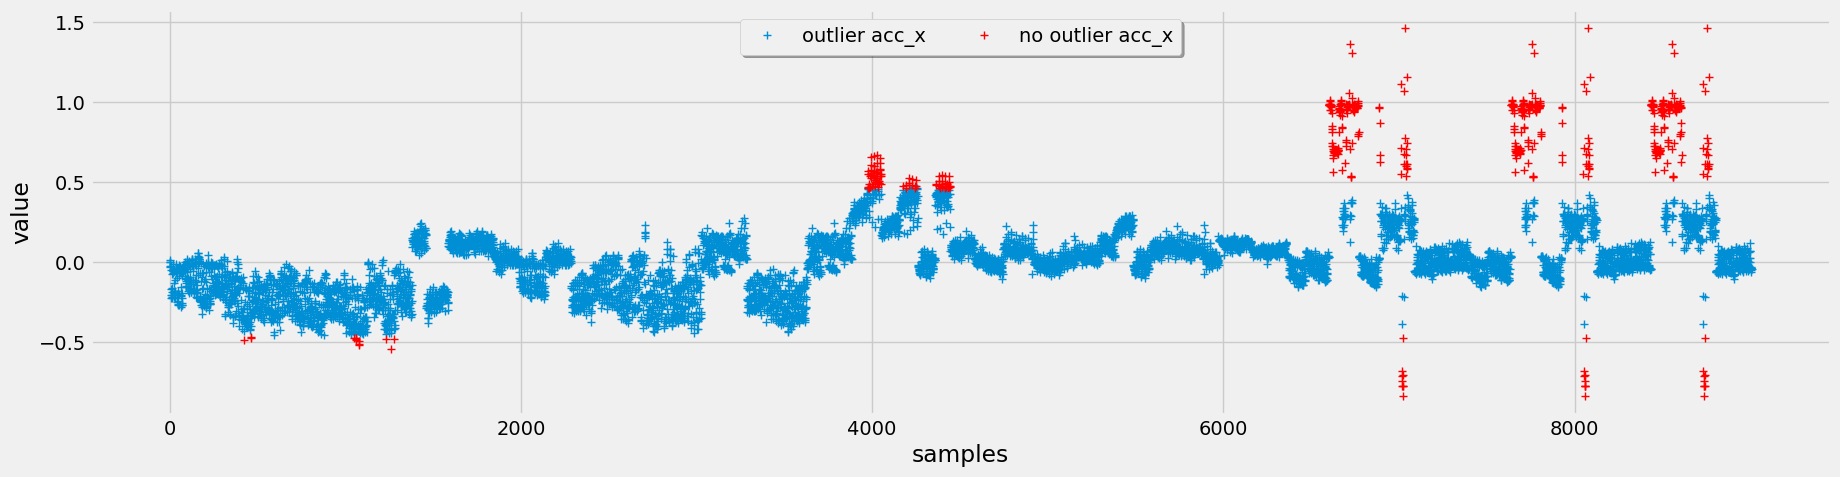

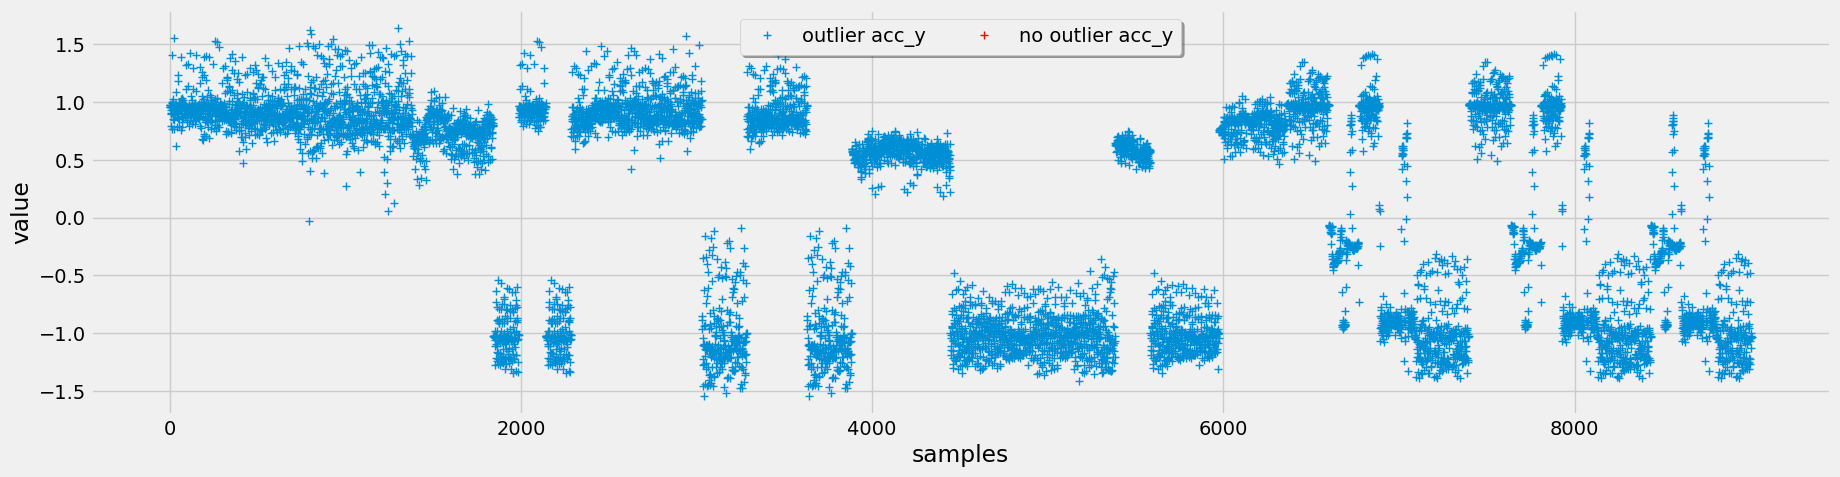

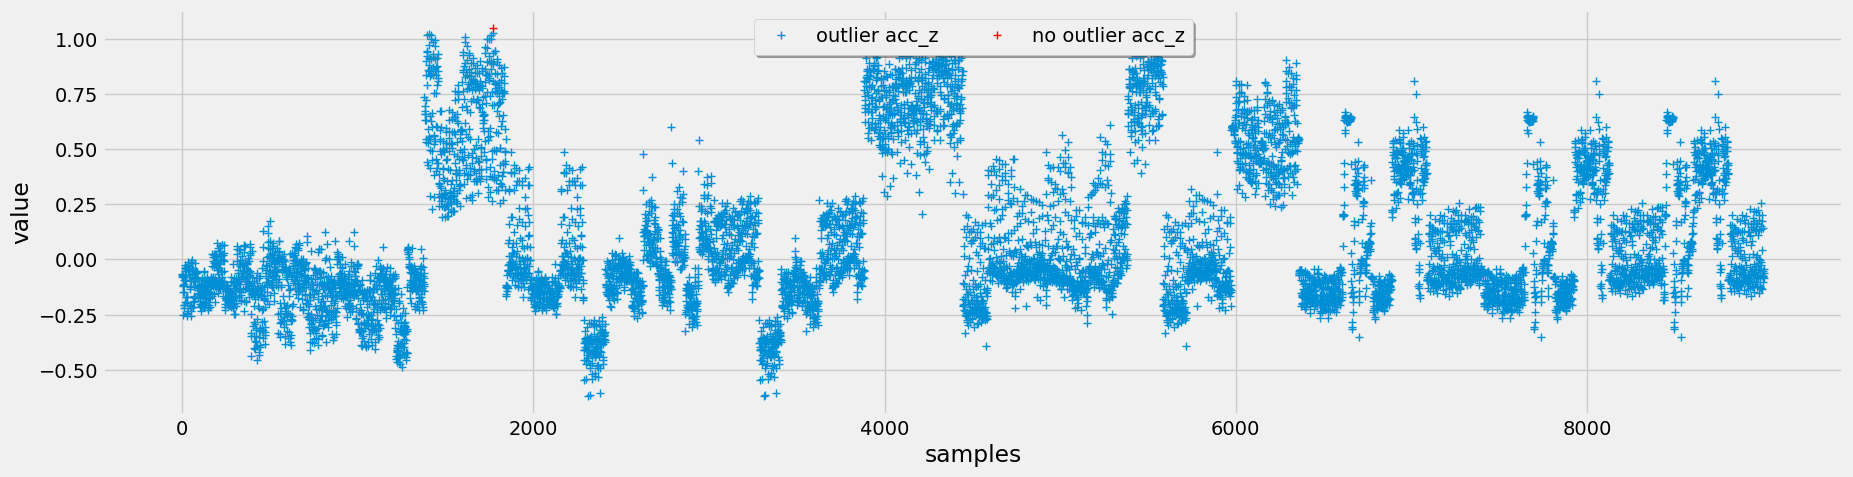

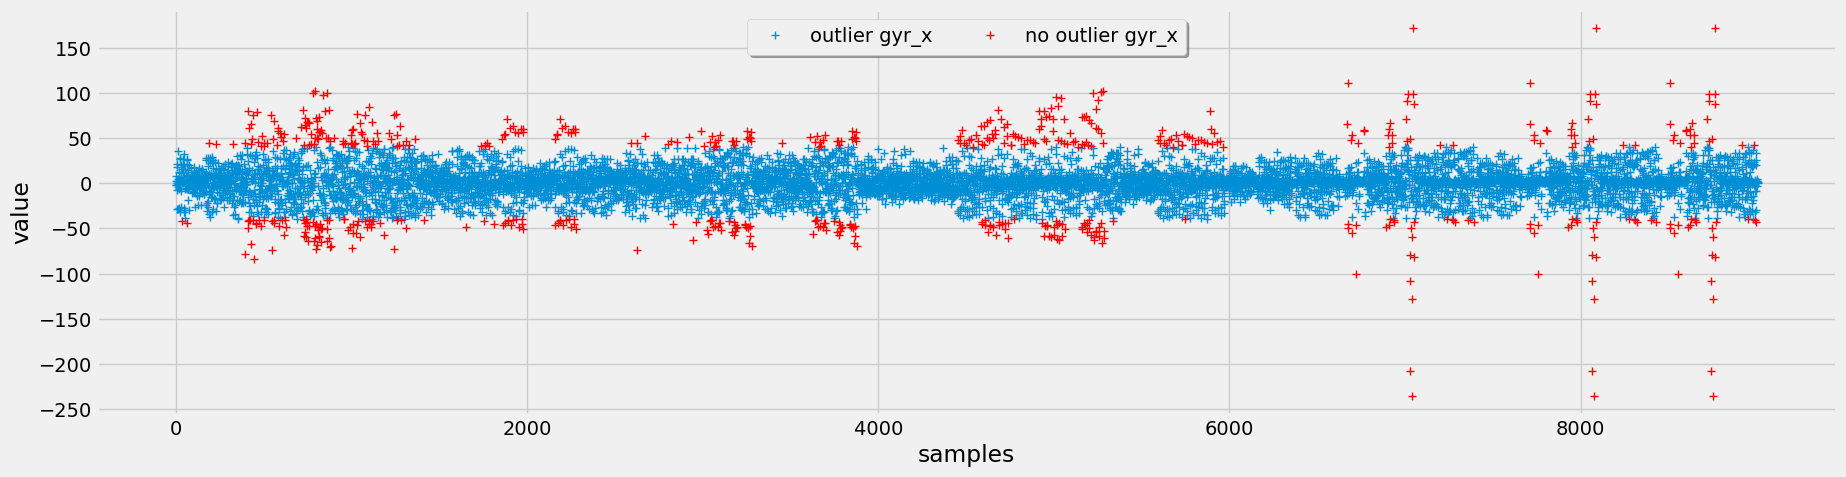

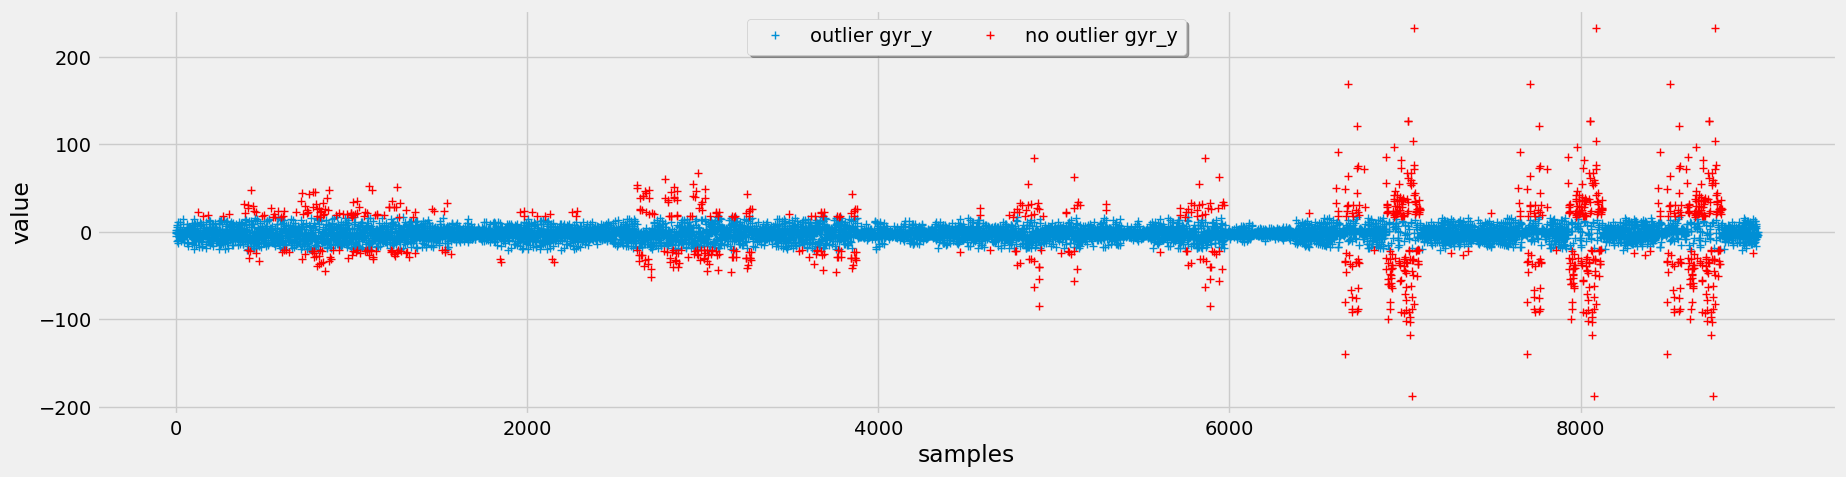

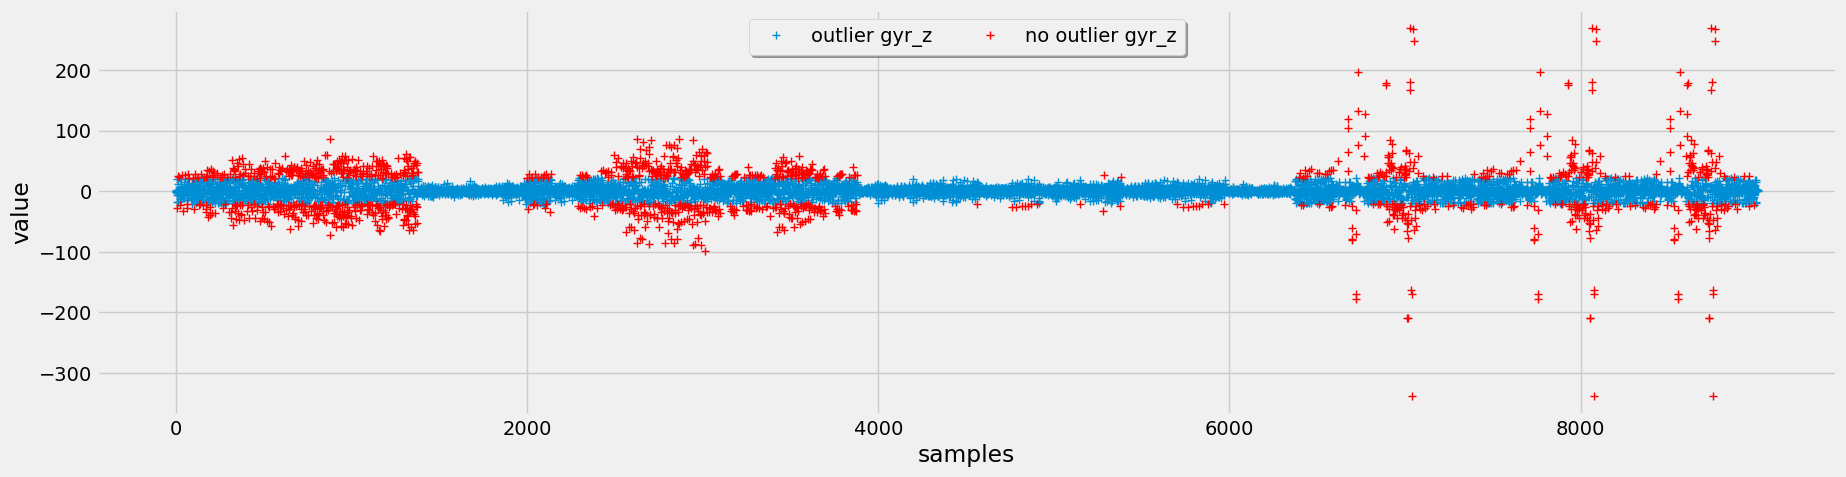

In [95]:
# Plot a single column
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(
    dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
)

# Loop over all columns
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

As seen above, using the IQR method still shows too many outliers and many of these flagged data points may be legit. Another method should be attempted before making a final decision on handling outliers.

#### 4.4 - Chauvenet's Criterion for Outlier Detection

Chauvenet's criterion is a method for detecting outliers based on the idea that for normally distributed data, the probability of an outlier is relatively low. This won't work if the data isn't normally distributed, however. 

This method rejects an outlier from a dataset of size `N` when the probability of such observation is less than `1 / (C * N)` where `C` is usually 2.

Source: Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.

Source code of Chauvenet's function can be found here:

https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

Define `mark_outliers_chauvenet()` as follows:

In [96]:
def mark_outliers_chauvenet(dataset, col, C=2):
    dataset = dataset.copy()

    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):

        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )

        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)

    dataset[col + "_outlier"] = mask
    return dataset

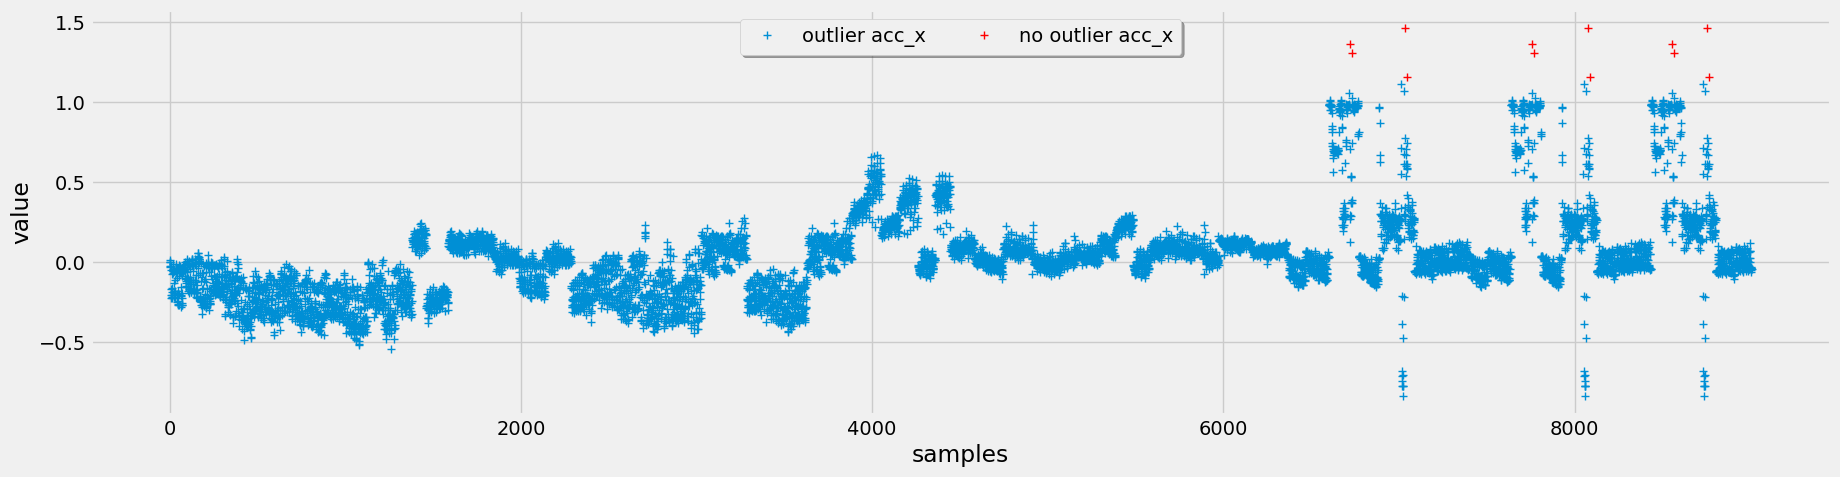

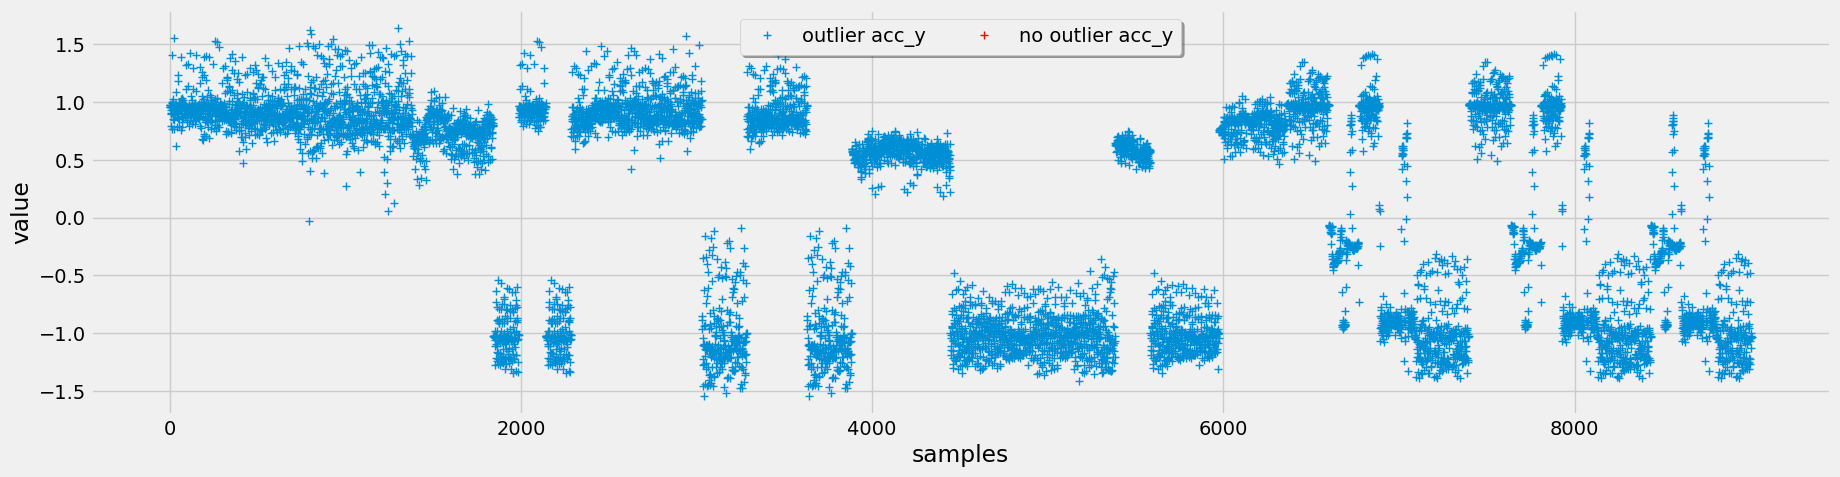

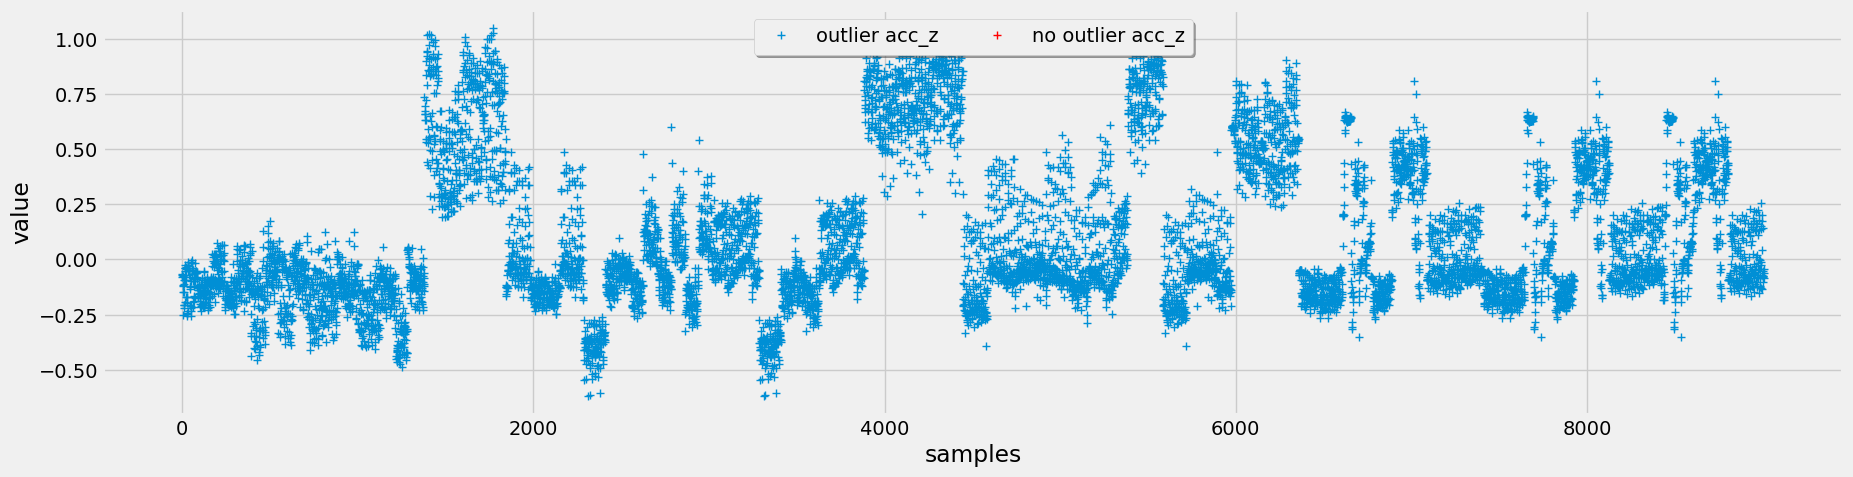

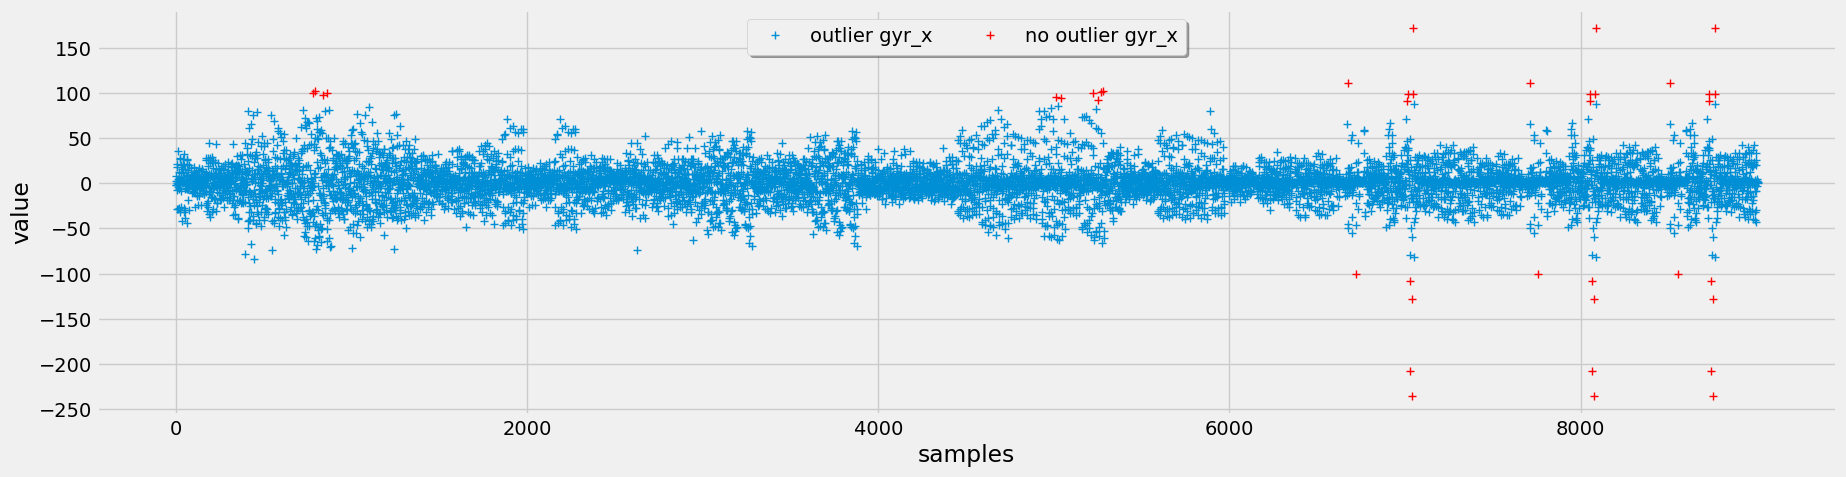

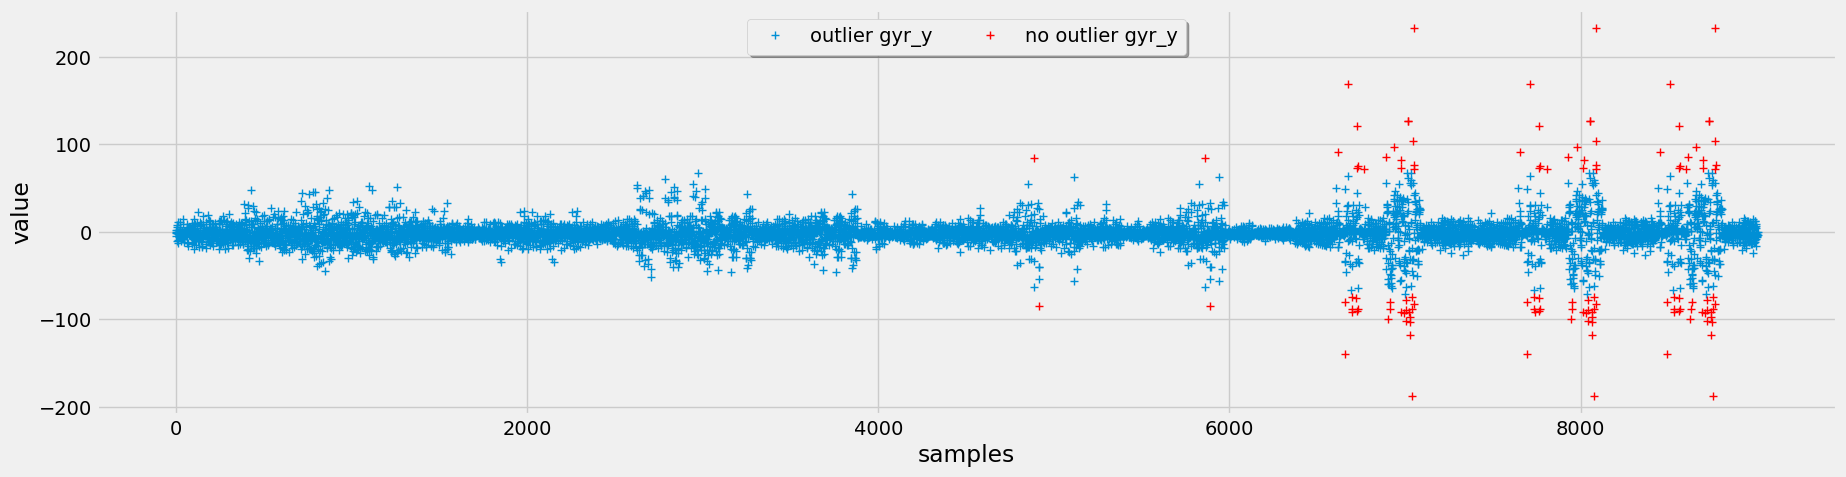

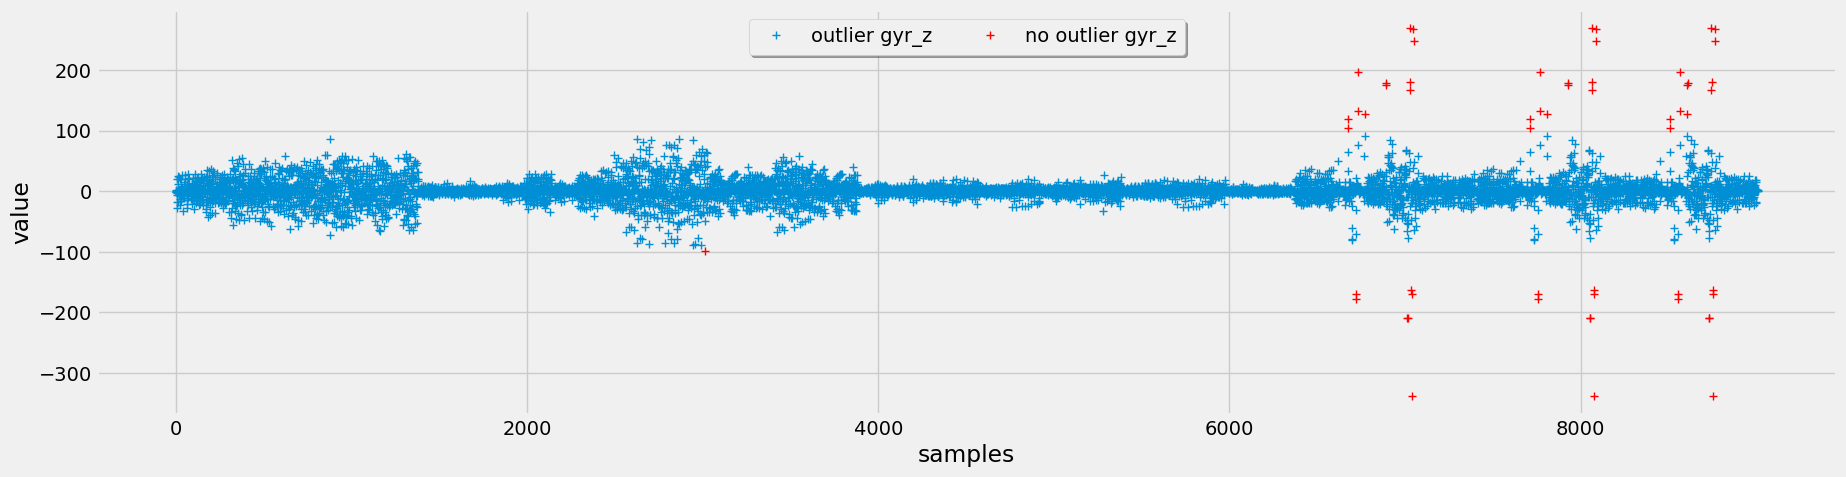

In [97]:
# Test the Chauvenet criterion on all columns
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )


Using Chauvenet's method results in less outliers, which likely means they are true outliers.

#### 4.5 - Local Outlier Factor (LOF)

LOF is an unsupervised outlier detection method that assigns an anomaly score to each observation. The anomaly score is based on the distance of a sample with respect to its neighbors. 

In [100]:
from sklearn.neighbors import LocalOutlierFactor

def mark_outliers_lof(dataset, columns, n=20):
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1

    return dataset, outliers, X_scores


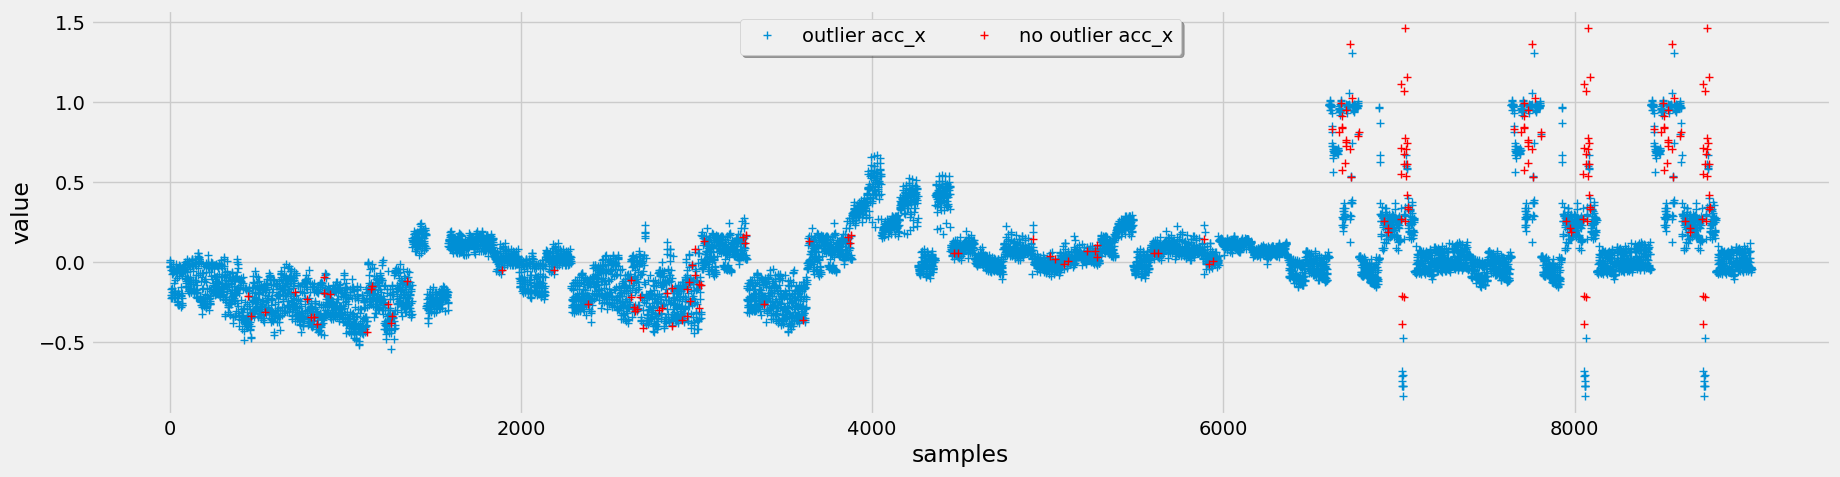

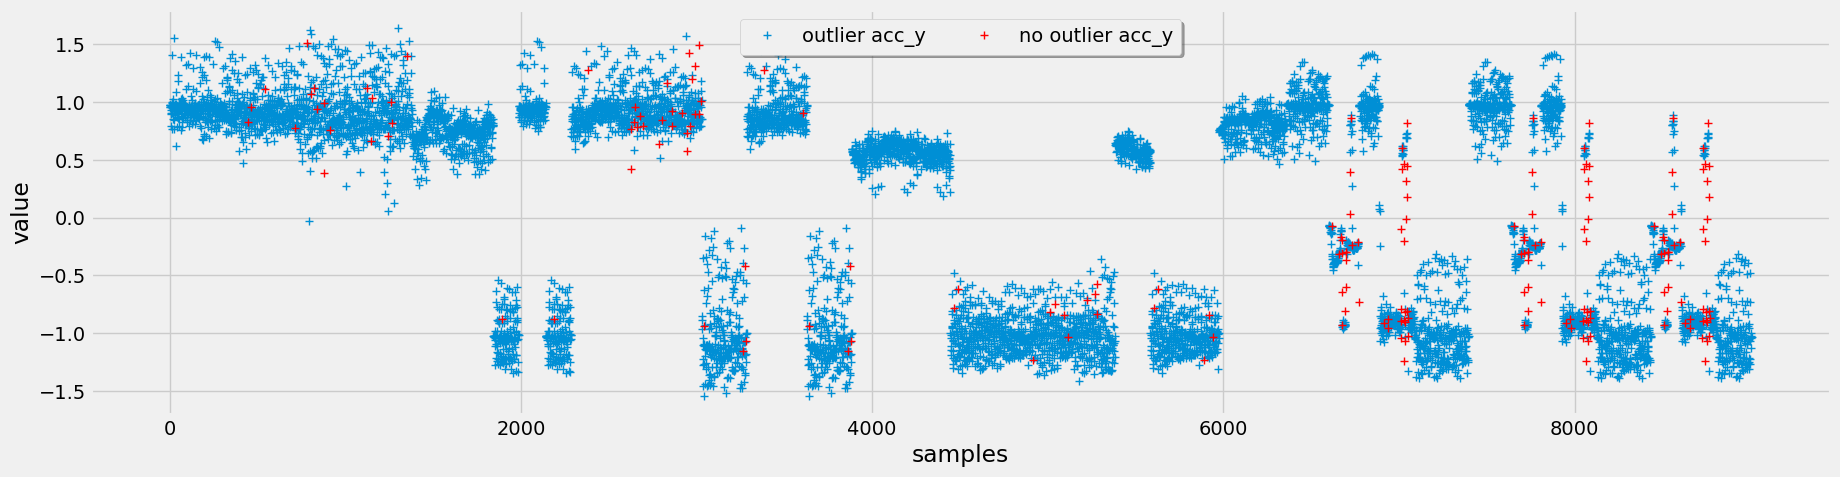

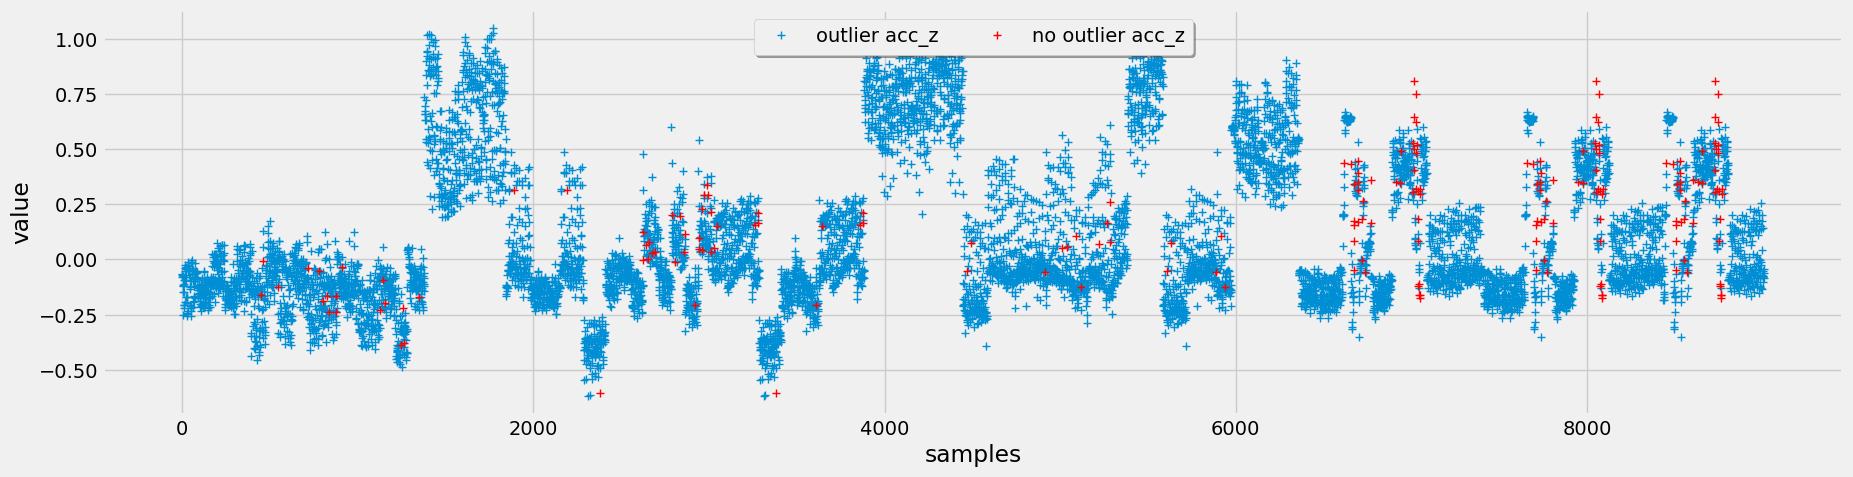

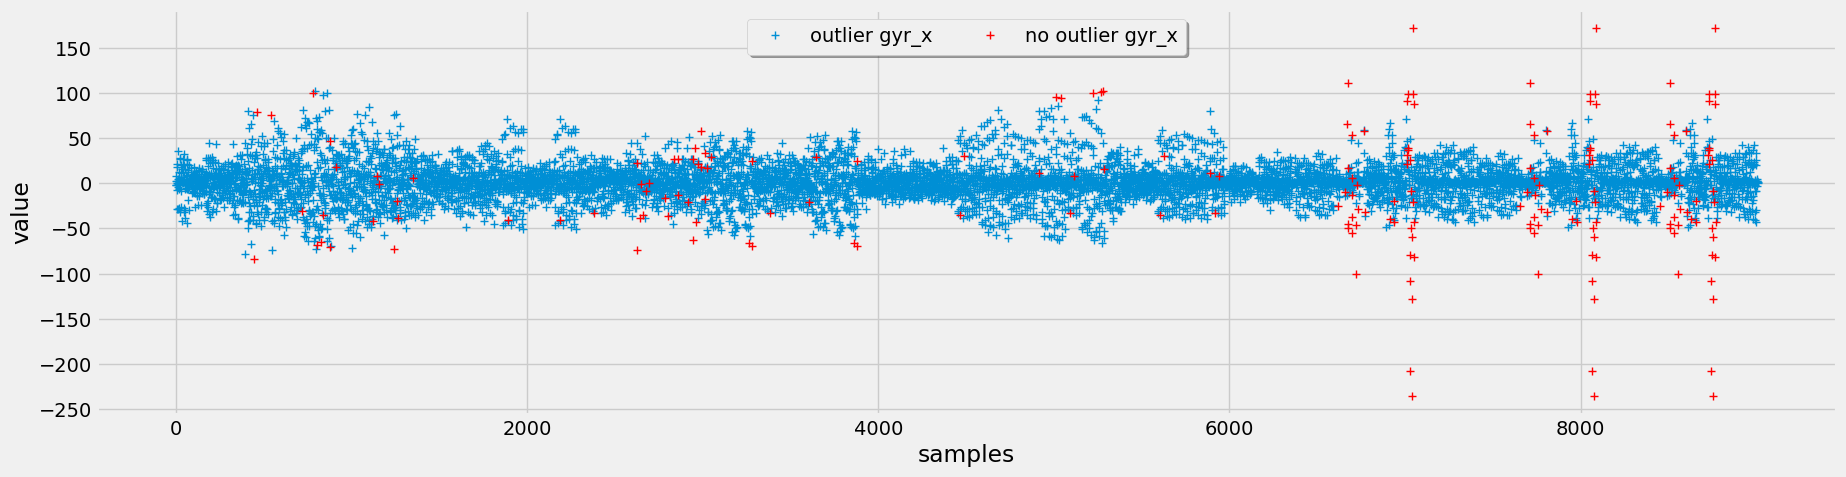

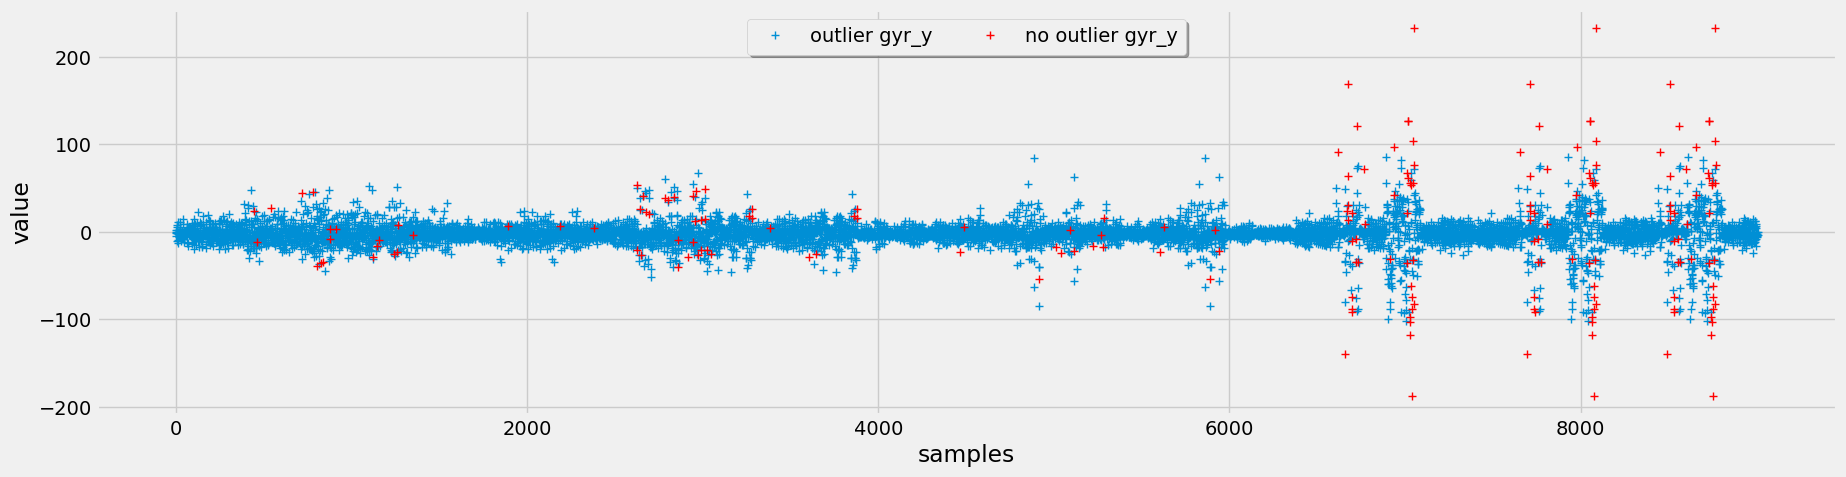

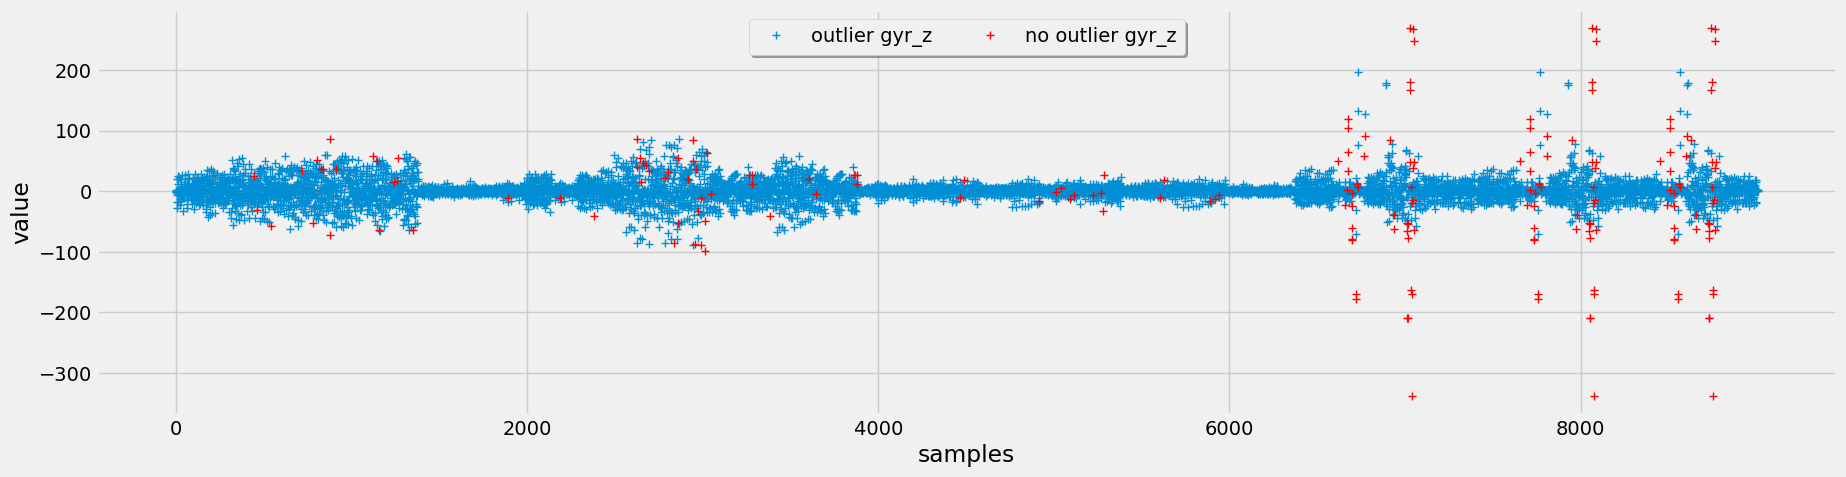

In [101]:
# Test the LOF method on all columns
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(
        dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True
    )

The LOF method found outliers that seem within normal ranges but are identified as isolated data points due to distance from other clusters. 

#### 4.6 - Check for Outliers Grouped by Excercise Type